# R211S: Analyze contact interactions of Hv1-2GBI system.

By: Victoria Lim  
Last updated: 2018-04-11

This notebook processes the pickled pandas dataframe of contact interactions. The contact interactions are based off graph representation of protein-ligand system and are calculated using Tcl scripts with VMD (see references below).  

Pickle file details:
- Generated from: `/beegfs/DATA/mobley/limvt/hv1/04_fep/postFEPvanilla/analysis/3_nonCovInts/nodeContacts.py`
- Pickle dump line: `pickle.dump((nodes, edges), open( pickleOut, "wb" ) )`

**Notebook inputs**:  
Nodes and edges are pandas dataframes as generated in the above script.
- Node example:

|index|resname | resid | location | type | code | nAtoms |
|-----|--------|-------|----------|------|------|--------|					
|1|	PHE|	88|	bb|	POS|	NT|	1|
|2|	PHE|	88|	sc|	NOP|	AB|	2|
|3|	PHE|	88|	sc|	NOP|	GDEZ|	6|
|4|	ARG|	89|	sc|	NOP|	AB|	2|
|5|	ARG|	89|	sc|	NOP|	GD|	2|

- Node details:
  - TODO



- Edge example:

||node_i | node_j | weight | attribute | count | average |
------------------------------------------------------- |
|34647 |	165 | 174 |	132 |	HPHOB | 97.0 | 1.360825 |
|34648 |	165	| 175 | 322 |	HPHOB | 130.0 | 2.476923 |

- Edge details:
  - First column is the pandas dataframe index. This value is not significant.
  - `node_i`: TODO -- include notes from README and reference for Benson&Daggett
  - `node_j`: The node interacting with `node_i`. The value of `node_j` should always be greater than or equal to that of `node_i`.
  - `weight`: Each node has a variable number of atoms. The weight of an interaction is the number of interactions for the atoms in `node_i` to the atoms in `node_j`. The weight listed is the sum over all frames of the weights found for this node pair.
  - `attribute`
  - `count`: Number of trajectory frames this edge interaction was found.
  - `average`: This is taken as the quotient of `weight`/`count`.

**Troubleshooting**:
* If you subtract two edge dataframes and lose most interactions, it might be that the node indices don't match up.   
  * For example, let's say dataframe_1 has the node_35 to node_99 interaction as an HBOND,  
but dataframe_2 shows the node_35 to node_99 interaction as COUL (Coulombic) interaction.  
There was a mutation associated with dataframe_2, which knocked out 5 nodes, starting at node_80.  
Then the real match of dataframe_1's node_35 to node_99 for dataframe_2 is with node_35 to node_94.  
  * This _shouldn't_ be an issue since the `diffEdges` function should take out any edge involving  
any mutation-related notes, and then scale the rest of the edges by that offset.  
(By the way, this function does have a pretty limited use-case currently, so check the documentation.)
  * To determine if this is the case, look for the line:  
`diff_edges_x = noMut_edges_x.merge(noMut_edges_y,on=['node_i','node_j','attribute'],how='inner')`  
(or the analogus merge line), and take out the requirement to match on attribute as well as on nodes:  
`diff_edges_x = noMut_edges_x.merge(noMut_edges_y,on=['node_i','node_j',],how='inner')`.  
Print and scrutinize the resulting edges dataframe, such as using `head()`, `tail()` or `iloc[range1:range2]`.

* If you `.apply` some function to a pandas dataframe column and get some error:  
Try iterating over the column and applying that function one-by-one to look for the bug.  
`for i, (index, row) in enumerate(diff_edges_1.iterrows()):`

* If you see `SettingWithCopyWarning`, it's probably because you're altering some dataframe that's likely a copy of the original. That might be fine if you have just one change to make (e.g., I was able to increment all of `node_i`). However, if you have to work with it further, then consider wrangling with `.loc` (or similar) functions for modifying the bona fide dataframe (e.g., when I then tried to increment `node_j`, the original changes to `node_i` were gone).

**References**:
* Nodes and edges of protein adapted from [Benson and Daggett](https://dx.doi.org/10.1142%2FS0219720012500084).
* Tcl scripts written by Eric Wong and Alfredo Freites. 

**Questions to self**:
* For a heat map of edge differences, such as before and after mutation, what cutoff is significant? Do you notice in the trajectory, for example, when the data says the interaction between F150 and 2GBI:benzo decreases by '-5'?

___________________________________________________________________

**TODO**: 
* subtract edges for 2GBI taut2 and taut1 by connecting benzo--benzo, guan--guan, CNN--(NN+CN)
* update function documentation to numpy format
   * https://github.com/numpy/numpydoc/blob/master/doc/example.py
   * https://samnicholls.net/2016/06/15/how-to-sphinx-readthedocs/
* make the heatplot a 3D plot colored by inttype (e.g., COUL)
* is it valid to subtract edge data when the averages may have come from different-length trajectories?

**Glossary of some variables defined in this notebook**

Nodes
* nodes_1             : nodes of mutant, read from file
* wt_nodes_1          : nodes of WT, read from file
* diff_nodes_1        : nodes of WT, mutation residue removed
* dry_diff_nodes_1    : nodes of WT, mutation residue removed, sumWat node added

Edges
* edges_1             : normal edges of mutant, read from file
* wt_edges_1          : normal edges of WT, read from file
* diff_edges_1        : normal edges of (mutant-WT) interactions, mutation residue removed
* dry_diff_edges_1    : normal edges of (mutant-WT) interactions, mutation residue removed, all water interactions summed
* pivot_diff_edges_1  : pivoted edges of DRY (mutant-WT) interactions

2GBI
* mut_gbi1_edges      : pivoted edges of 2GBI interactions in mutant
* wild_gbi1_edges     : pivoted edges of 2GBI interactions in WT
* sim_mut_gbi1_edges  : pivoted edges of 2GBI interactions common to mutant and WT

Water
* waterEdges_1        : pivoted edges of sumWat interactions
* sim_waterEdges_1    : pivoted edges of sumWat interactions common to taut1 and taut2

**Table of Contents**  

1. Load in data  
    1. Demonstrate some functions defined in this notebook

2. Analyze interactions before and after mutation
    1. Focus on whole protein-ligand system
        1. Tautomer 1
        2. Tautomer 2
        3. No ligand
    1. Focus on ligand-specific interactions
        1. Tautomer 1
        2. Tautomer 2
        3. No ligand
    1. Focus on relative hydration by residue
        1. Tautomer 1
        2. Tautomer 2
        3. Both tautomers in common
        4. Verify hydration in edges
    1. Focus on other defined interactions
        1. D112
        2. D185
        3. R211
        
3. Analyze interactions differentiating tautomers
    1. Focus on whole protein-ligand system
        1. After mutation
        2. Before mutation
    1. Focus on ligand-specific interactions
        1. After mutation
        2. Before mutation

4. Analyze differences wrt thermodynamic cycle
    1. Tautomer 1
    2. Tautomer 2

5. Analyze interactions directly from computed edges
    1. Focus on whole protein-ligand system
        1. After mutation
            1. Tautomer 1
            1. Tautomer 2
        2. Before mutation

6. Troubleshooting

In [1]:
import sys
sys.path.insert(0, '../')
from nodeAnalysis import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

np.__file__

'/home/limvt/local/lib/anaconda3/lib/python3.6/site-packages/numpy/__init__.py'

In [2]:
# define global variables for this notebook
mutcode = 'R211S'

# I. Load in data

In [3]:
# load in data for after mutation
nodes_0, edges_0 = pickle.load( open( 't0_s211.pickle', "rb" ))
nodes_1, edges_1 = pickle.load( open( 't1_s211.pickle', "rb" ))
nodes_2, edges_2 = pickle.load( open( 't2_s211.pickle', "rb" ))

In [4]:
# load in data for wild type, before mutation
wt_nodes_0, wt_edges_0 = pickle.load( open( 't0_wt.pickle', "rb" ))
wt_nodes_1, wt_edges_1 = pickle.load( open( 't1_wt.pickle', "rb" ))
wt_nodes_2, wt_edges_2 = pickle.load( open( 't2_wt.pickle', "rb" ))

In [5]:
# fix node_0 because it has 2GBI (but is ok since 2GBI not in edges)
nodes_0 = nodes_0[~nodes_0.resname.isin(['GBI1'])]

In [6]:
# only analyze edges that involve transmembrane region
edges_0 = trimEdgesTM(nodes_0, edges_0)
edges_1 = trimEdgesTM(nodes_1, edges_1)
edges_2 = trimEdgesTM(nodes_2, edges_2)

In [7]:
edges_1.tail()

,node_i,node_j,weight,attribute,count,average
71069,408,8364,1,HBOND,1.0,1.00000
71070,408,10632,1,HBOND,1.0,1.00000
71071,408,10636,2,HBOND,2.0,1.00000
71072,408,10931,4,HBOND,2.0,2.00000
71073,408,10979,87,HBOND,32.0,2.71875


In [8]:
nodes_1.loc[nodes_1['resname'] == 'GBI1']

,resname,resid,location,type,code,nAtoms
index,,,,,,
11230,GBI1,230,lg,NOP,BENZ,6
11231,GBI1,230,lg,DIP,NN,1
11232,GBI1,230,lg,DIP,CN,2
11233,GBI1,230,lg,POS,GUAN,4


In [9]:
nodes_2.loc[nodes_2['resname'] == 'GBI2']

,resname,resid,location,type,code,nAtoms
index,,,,,,
11227,GBI2,230,lg,NOP,BENZ,6
11228,GBI2,230,lg,POS,CNN,3
11229,GBI2,230,lg,DIP,GUAN,4


## A. Demonstrate some functions defined in this notebook

In [10]:
findInEdges(413, wt_edges_1,'STER')

,node_i,node_j,weight,attribute,count,average
80287,402,413,135,STER,115.0,1.173913
80693,405,413,381,STER,250.0,1.524000
80751,408,413,2490,STER,250.0,9.960000
80844,410,413,1250,STER,250.0,5.000000
81290,411,413,1535,STER,250.0,6.140000
82683,413,414,902,STER,250.0,3.608000


In [11]:
idxToResid(191, nodes_1,idOnly=False)

'F150:sc'

In [12]:
getResidInfo(211, nodes_2)

,resname,resid,location,type,code,nAtoms
index,,,,,,
381,SER,211,sc,NOP,AB,2
382,SER,211,sc,DIP,G,1
383,SER,211,bb,DIP,BB,3
657,WAT,211,wt,DIP,OH2,1


In [13]:
getResidInfo(211, nodes_2, resExcludes=['WAT'])

,resname,resid,location,type,code,nAtoms
index,,,,,,
381,SER,211,sc,NOP,AB,2
382,SER,211,sc,DIP,G,1
383,SER,211,bb,DIP,BB,3


In [14]:
getEdgePair(413,420,wt_edges_1)

,node_i,node_j,weight,attribute,count,average
82688,413,420,7,HBOND,7.0,1.0


In [15]:
getContactPair(112, 211, nodes_1, edges_1)

      resname  resid location type code  nAtoms
index                                          
75        ASP    112       sc  NOP   AB       2
76        ASP    112       sc  NOP    G       1
77        ASP    112       sc  NEG    D       2
78        ASP    112       bb  DIP   BB       3 

       resname  resid location type code  nAtoms
index                                          
381       SER    211       sc  NOP   AB       2
382       SER    211       sc  DIP    G       1
383       SER    211       bb  DIP   BB       3


,node_i,node_j,weight,attribute,count,average
15359,77,382,5,HBOND,5.0,1.0


# II. Analyze interactions before and after mutation

## A. Focus on whole protein-ligand system

### 1. Tautomer 1

In [16]:
diff_nodes_1, diff_edges_1, mutstart_1, offset_1 = diffEdges(nodes_1,wt_nodes_1,edges_1,wt_edges_1)
dry_diff_nodes_1, dry_diff_edges_1 = condenseWaters(diff_nodes_1, diff_edges_1)

nodes in 1st, not in 2nd:  [381 382 383 384]
nodes in 2nd, not in 1st:  [381 382 383]
Shifting node indices by 1 for 22475 rows


../nodeAnalysis.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_change_i['node_i'] += offset
../nodeAnalysis.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_change_j['node_j'] += offset


The water indices range from 447 to 11230
The new index of the summed waters is 11235


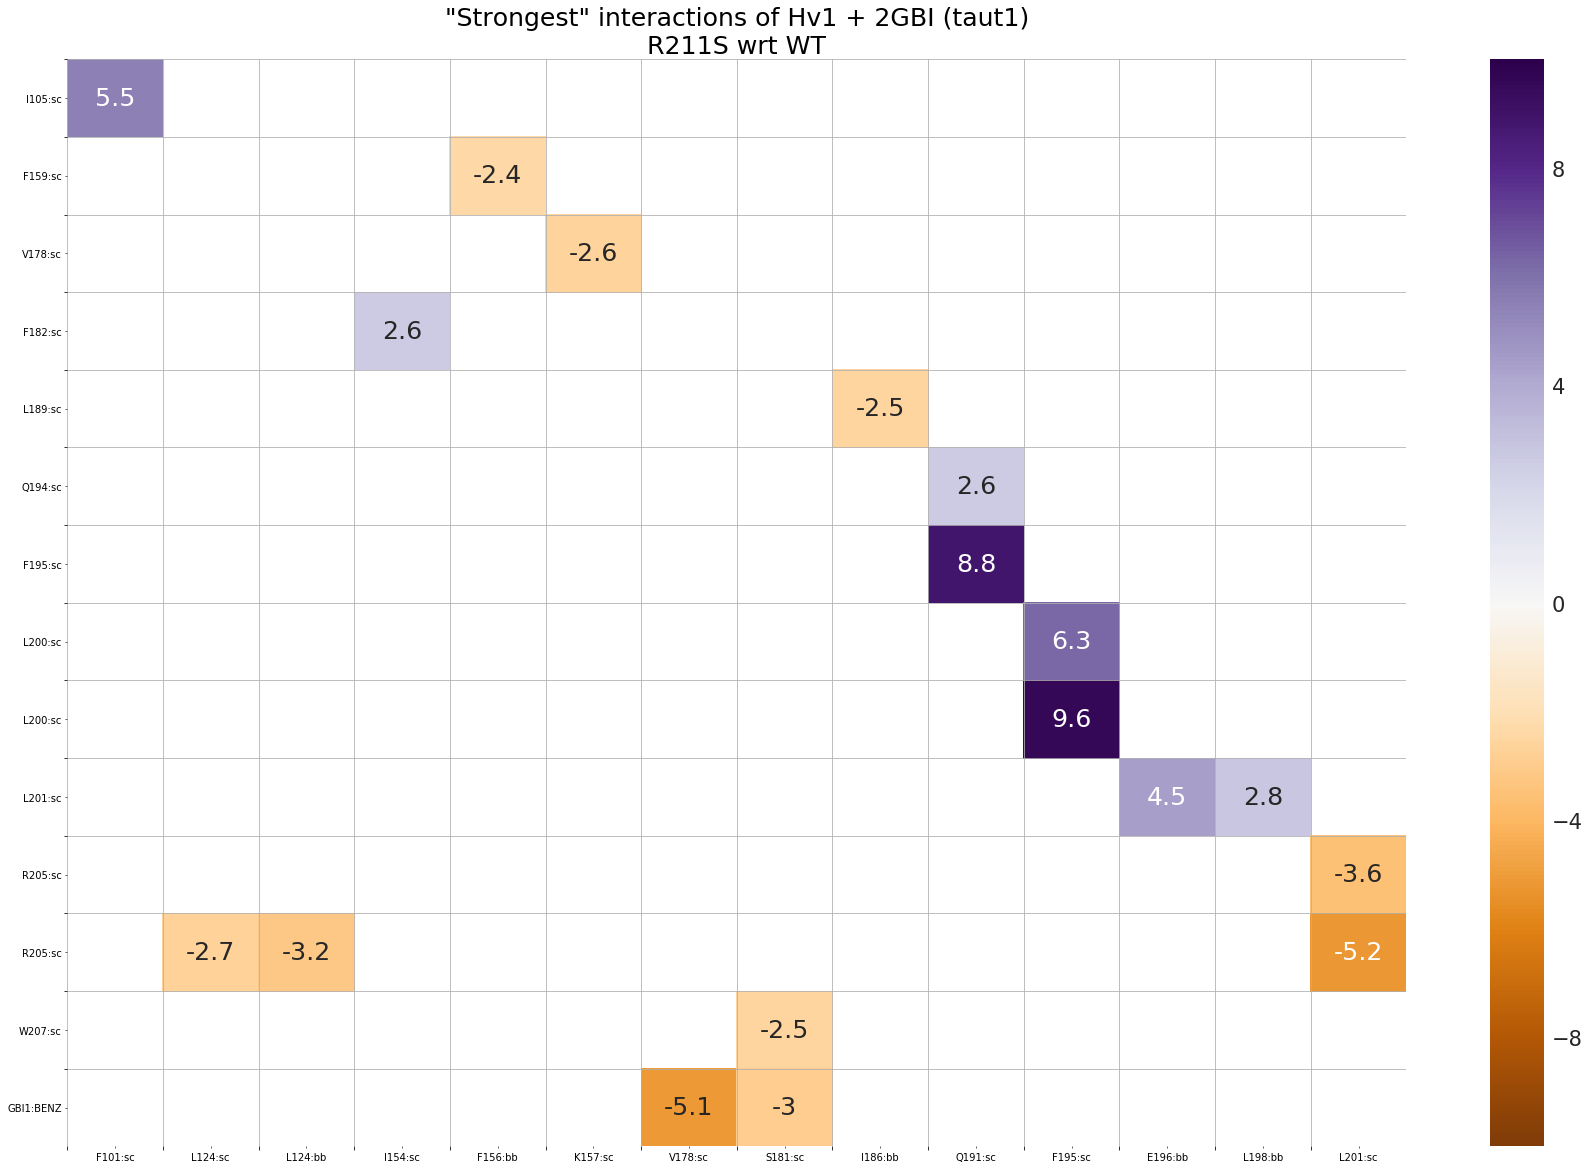

interaction range is from -10 to 10; verify if this is appropriate


In [17]:
pivot_diff_edges_1 = protLigInts(dry_diff_nodes_1, dry_diff_edges_1,rawNum=25,dry=2) # make sure you use REFERENCE nodes
plotHeatInts(dry_diff_nodes_1, pivot_diff_edges_1, minHeat=-10, maxHeat=10, colors='PuOr', size=(30,20),
             seltitle="Hv1 + 2GBI (taut1)\n{} wrt WT".format(mutcode))

### 2. Tautomer 2

In [18]:
diff_nodes_2, diff_edges_2, mutstart_2, offset_2 = diffEdges(nodes_2,wt_nodes_2,edges_2,wt_edges_2)
dry_diff_nodes_2, dry_diff_edges_2 = condenseWaters(diff_nodes_2, diff_edges_2)

nodes in 1st, not in 2nd:  [381 382 383 384]
nodes in 2nd, not in 1st:  [381 382 383]
Shifting node indices by 1 for 25749 rows


../nodeAnalysis.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_change_i['node_i'] += offset
../nodeAnalysis.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_change_j['node_j'] += offset


The water indices range from 447 to 11227
The new index of the summed waters is 11231


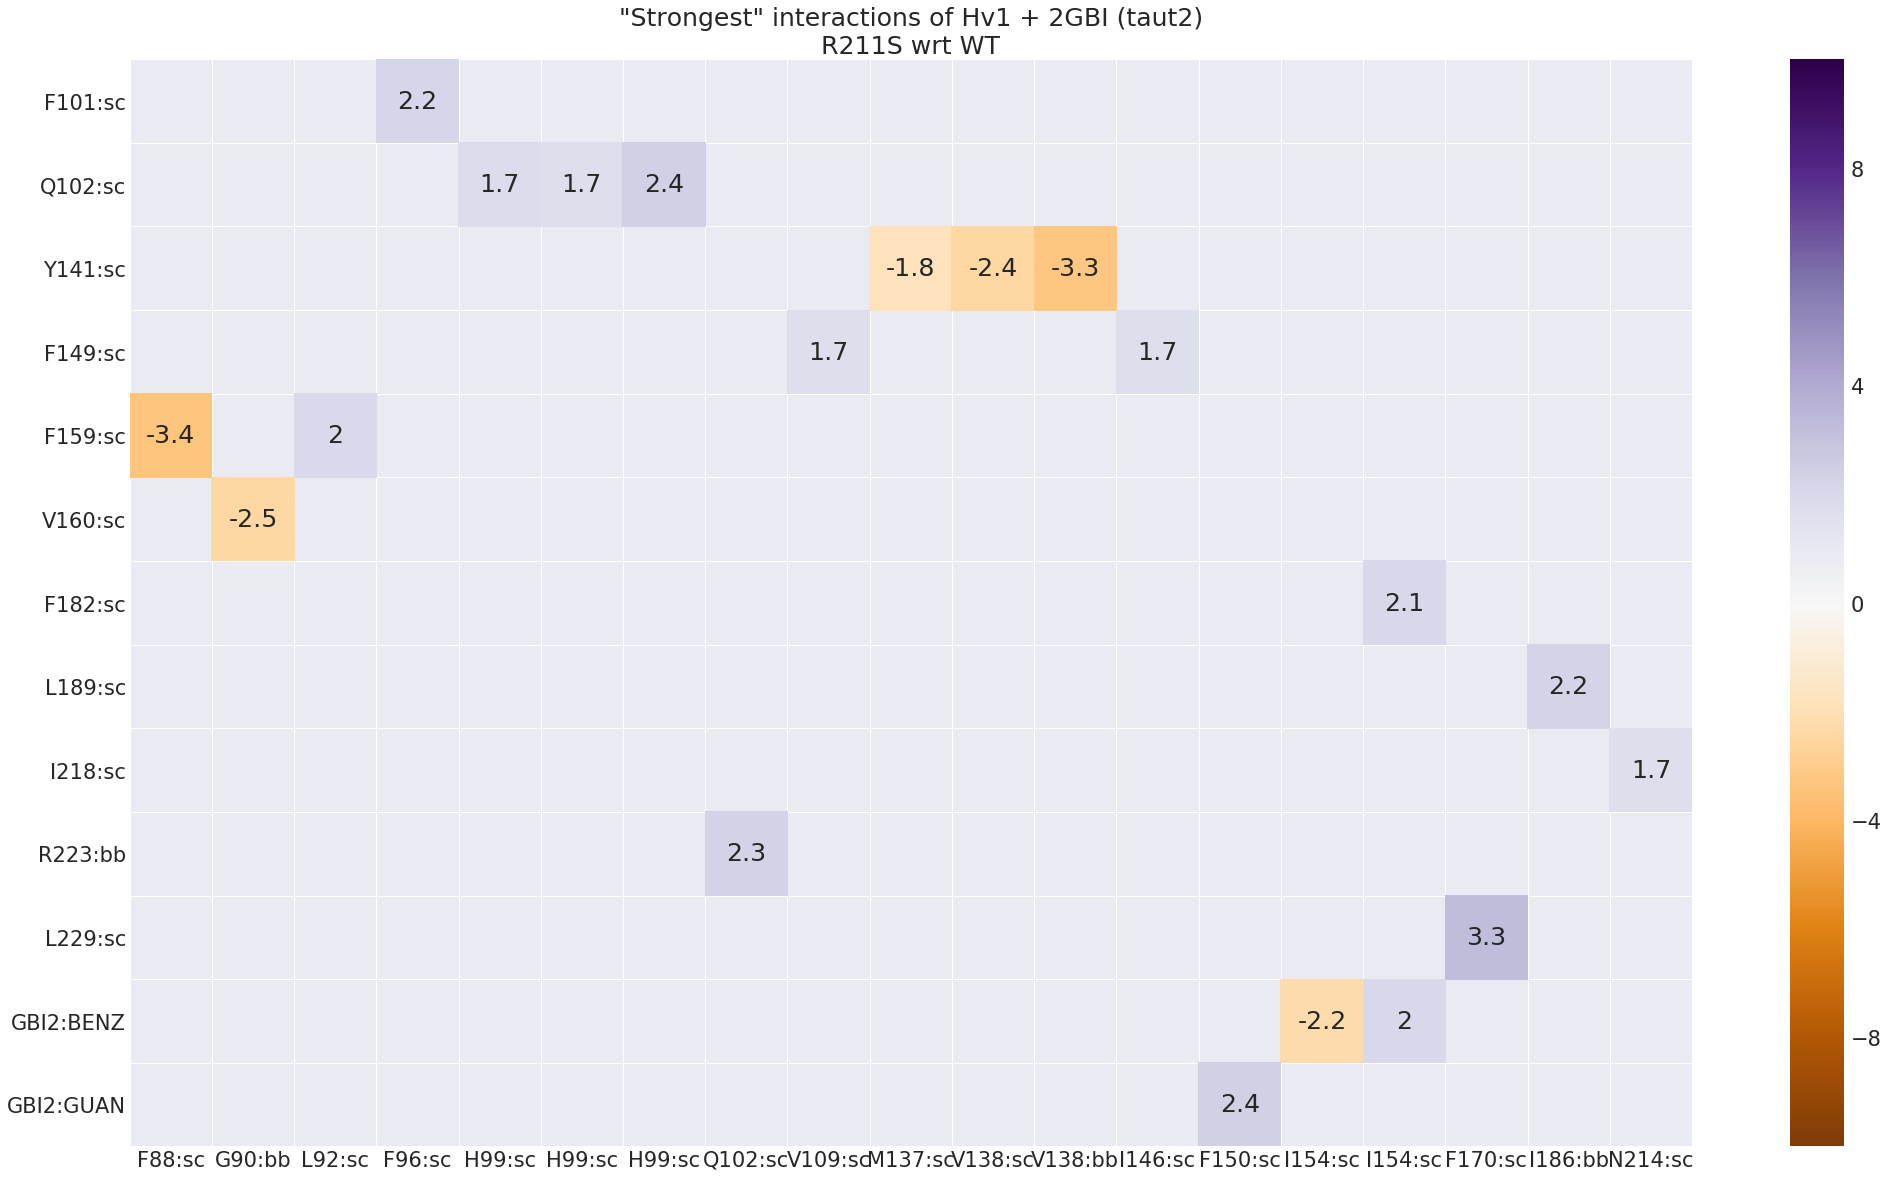

interaction range is from -10 to 10; verify if this is appropriate


In [19]:
pivot_diff_edges_2 = protLigInts(dry_diff_nodes_2, dry_diff_edges_2,rawNum=25,dry=2) # make sure you use REFERENCE nodes
plotHeatInts(dry_diff_nodes_2, pivot_diff_edges_2, minHeat=-10, maxHeat=10, colors='PuOr', size=(35,20),
             seltitle="Hv1 + 2GBI (taut2)\n{} wrt WT".format(mutcode))

### 3. No ligand

In [20]:
diff_nodes_0, diff_edges_0, mutstart_0, offset_0 = diffEdges(nodes_0,wt_nodes_0,edges_0,wt_edges_0)
dry_diff_nodes_0, dry_diff_edges_0 = condenseWaters(diff_nodes_0, diff_edges_0)

nodes in 1st, not in 2nd:  [381 382 383 384]
nodes in 2nd, not in 1st:  [381 382 383]
Shifting node indices by 1 for 19509 rows


../nodeAnalysis.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_change_i['node_i'] += offset
../nodeAnalysis.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_change_j['node_j'] += offset


The water indices range from 447 to 11234
The new index of the summed waters is 11235


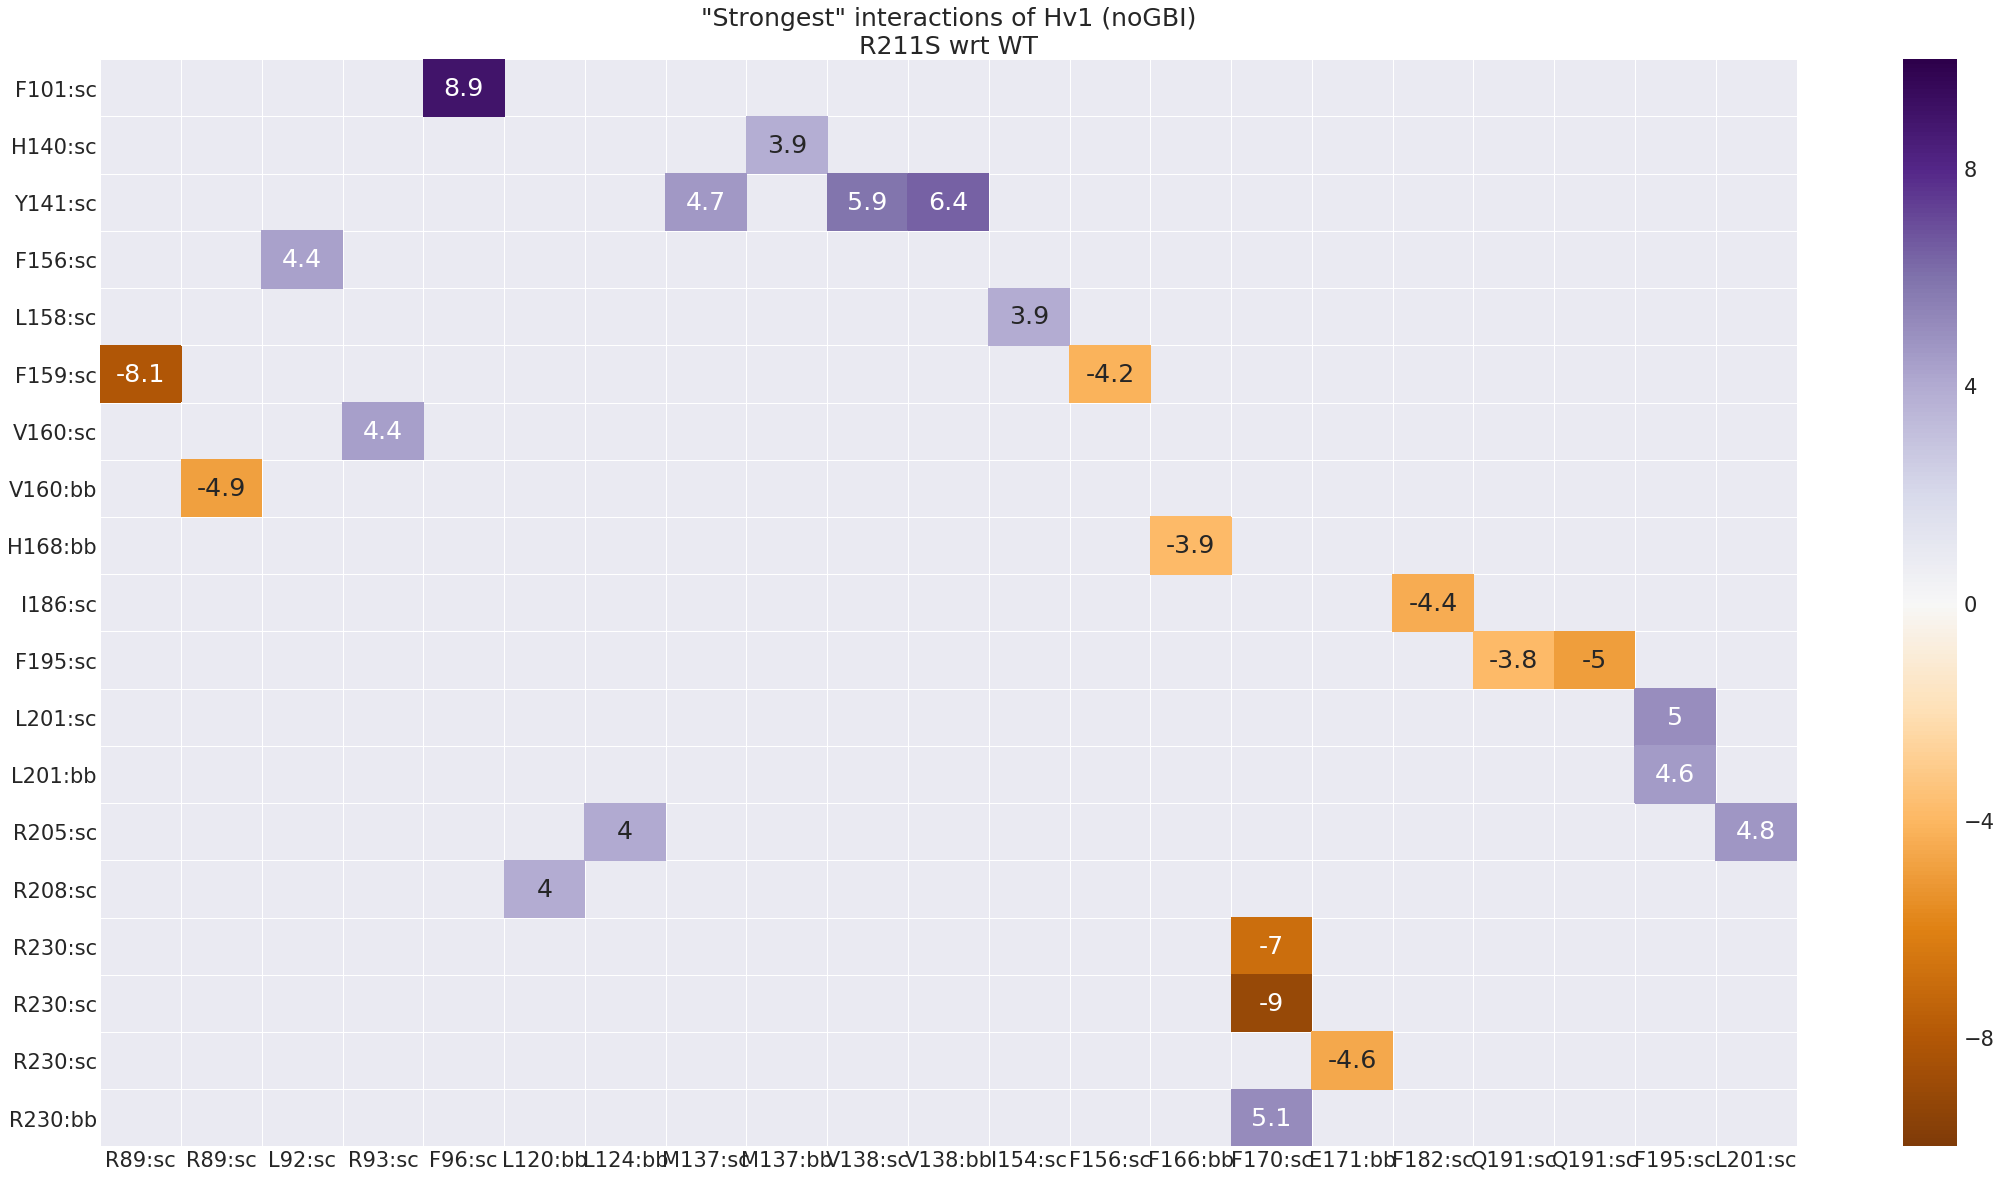

interaction range is from -10 to 10; verify if this is appropriate


In [21]:
pivot_diff_edges_0 = protLigInts(dry_diff_nodes_0, dry_diff_edges_0,rawNum=25,dry=2) # make sure you use REFERENCE nodes
plotHeatInts(dry_diff_nodes_0, pivot_diff_edges_0, minHeat=-10, maxHeat=10,colors='PuOr', size=(38,20),
             seltitle="Hv1 (noGBI)\n{} wrt WT".format(mutcode))

## B. Focus on ligand-specific interactions

### 1. Tautomer 1

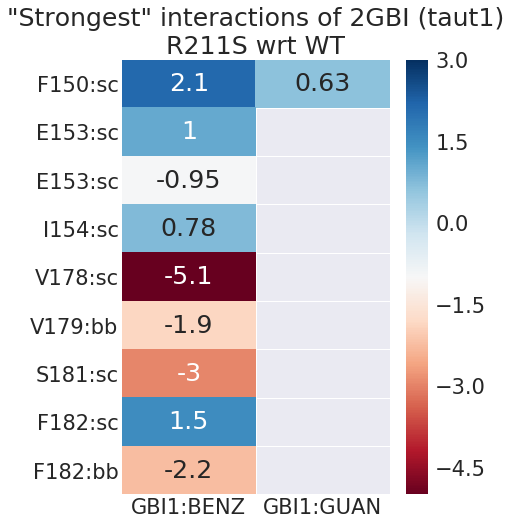

interaction range is from -5 to 3; verify if this is appropriate


In [22]:
# taut1 analysis (after-before) mutation
diff_gidx_1 = diff_nodes_1.index[diff_nodes_1['resname'] == 'GBI1'].tolist()
pivot_diff_gbi1_edges = selectionInts(dry_diff_nodes_1, dry_diff_edges_1, diff_gidx_1,rawNum=10)
plotHeatInts(dry_diff_nodes_1,pivot_diff_gbi1_edges,minHeat=-5,maxHeat=3,colors="RdBu",size=(6,8),
             seltitle='2GBI (taut1)\n{} wrt WT'.format(mutcode))

In [23]:
# taut1 analysis after mutation
gidx_1 = nodes_1.index[nodes_1['resname'] == 'GBI1'].tolist()
mut_gbi1_edges = selectionInts(nodes_1, edges_1, gidx_1,rawNum=1000)

In [24]:
# taut1 analysis before mutation
wt_gidx_1 = wt_nodes_1.index[wt_nodes_1['resname'] == 'GBI1'].tolist()
wild_gbi1_edges = selectionInts(wt_nodes_1, wt_edges_1, wt_gidx_1,rawNum=1000)

node_i's in common:  [11232 11233]
node_j's in common:  [ 75  76  77 180 181 185 189 191 192 193 196 200 201 202 204 205 206 213
 214 282 285 288 289 291 292 293 296 300 301 302]


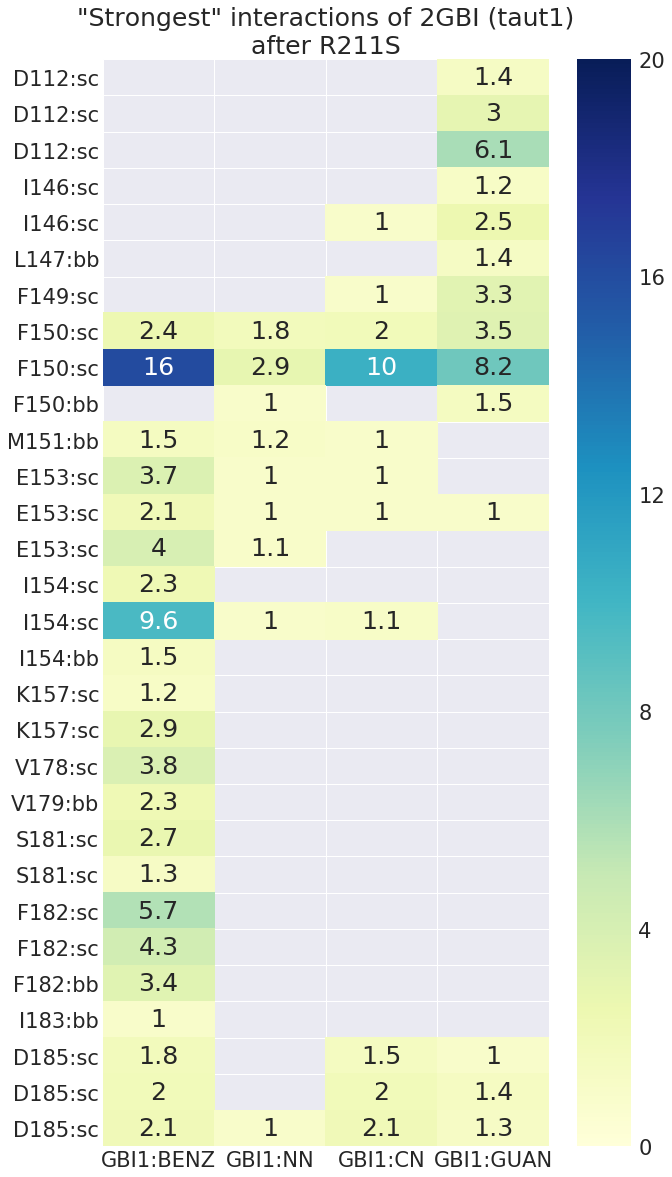

interaction range is from 0 to 20; verify if this is appropriate


In [25]:
# similarize edges before and after mutation
sim_mut_gbi1_edges, sim_wild_gbi1_edges = similarizeTwoEdges(mut_gbi1_edges, wild_gbi1_edges, mutstart=381, offset=1)
plotHeatInts(nodes_1,sim_mut_gbi1_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),
             seltitle='2GBI (taut1)\nafter {}'.format(mutcode))

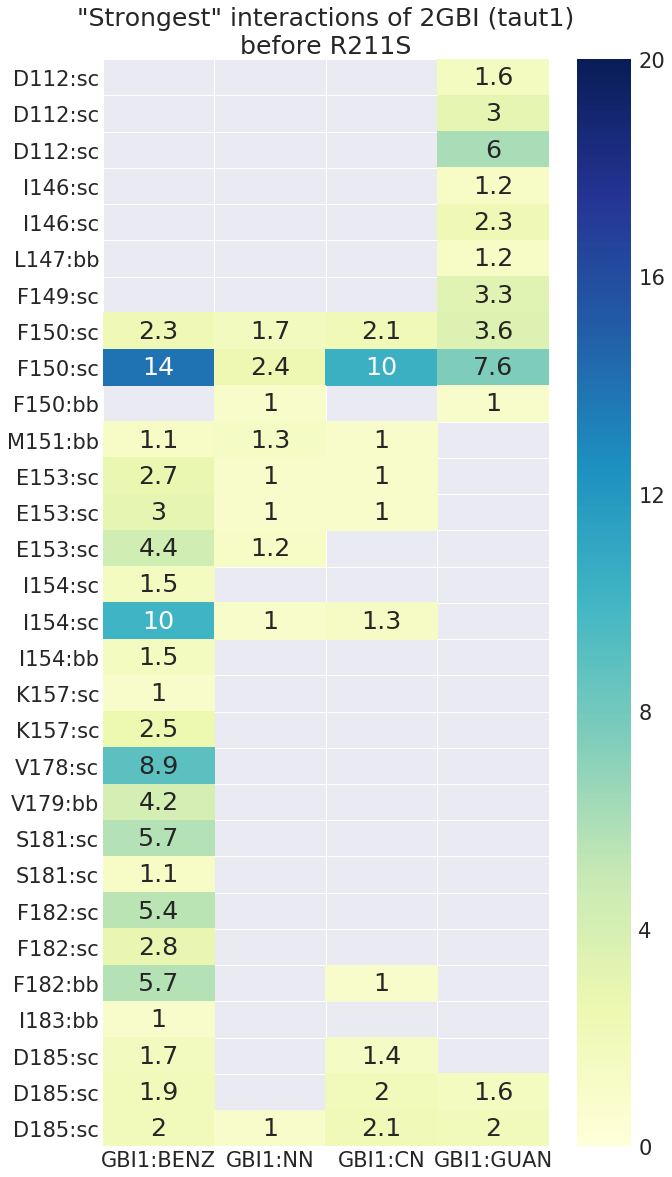

interaction range is from 0 to 20; verify if this is appropriate


In [26]:
plotHeatInts(wt_nodes_1,sim_wild_gbi1_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),
             seltitle='2GBI (taut1)\nbefore {}'.format(mutcode))

### 2. Tautomer 2

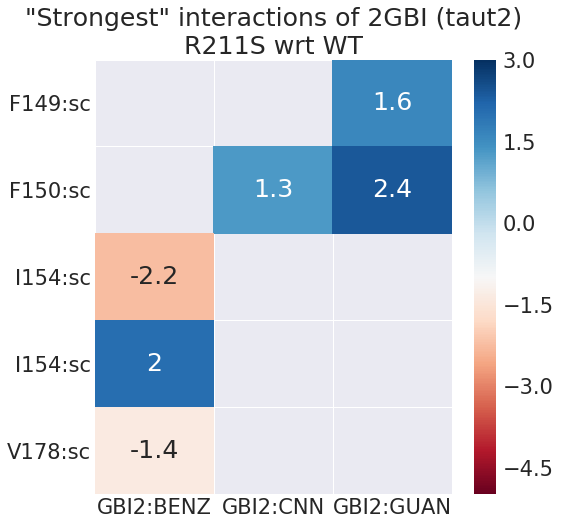

interaction range is from -5 to 3; verify if this is appropriate


In [27]:
# taut2 analysis (after-before) mutation
diff_gidx_2 = diff_nodes_2.index[diff_nodes_2['resname'] == 'GBI2'].tolist()
pivot_diff_gbi2_edges = selectionInts(diff_nodes_2, diff_edges_2, diff_gidx_2,rawNum=6)
plotHeatInts(diff_nodes_2,pivot_diff_gbi2_edges,minHeat=-5,maxHeat=3,colors="RdBu",size=(8,8),
             seltitle='2GBI (taut2)\n{} wrt WT'.format(mutcode))

In [28]:
# taut2 analysis after mutation
gidx_2 = nodes_2.index[nodes_2['resname'] == 'GBI2'].tolist()
mut_gbi2_edges = selectionInts(nodes_2, edges_2, gidx_2,rawNum=1000)

In [29]:
# taut2 analysis before mutation
wt_gidx_2 = wt_nodes_2.index[wt_nodes_2['resname'] == 'GBI2'].tolist()
wild_gbi2_edges = selectionInts(wt_nodes_2, wt_edges_2, wt_gidx_2,rawNum=1000)

node_i's in common:  [11229]
node_j's in common:  [ 75  76  77 180 181 185 189 191 192 193 196 200 201 202 204 205 206 214
 215 282 285 288 289 291 292 293 296 300 301 302]


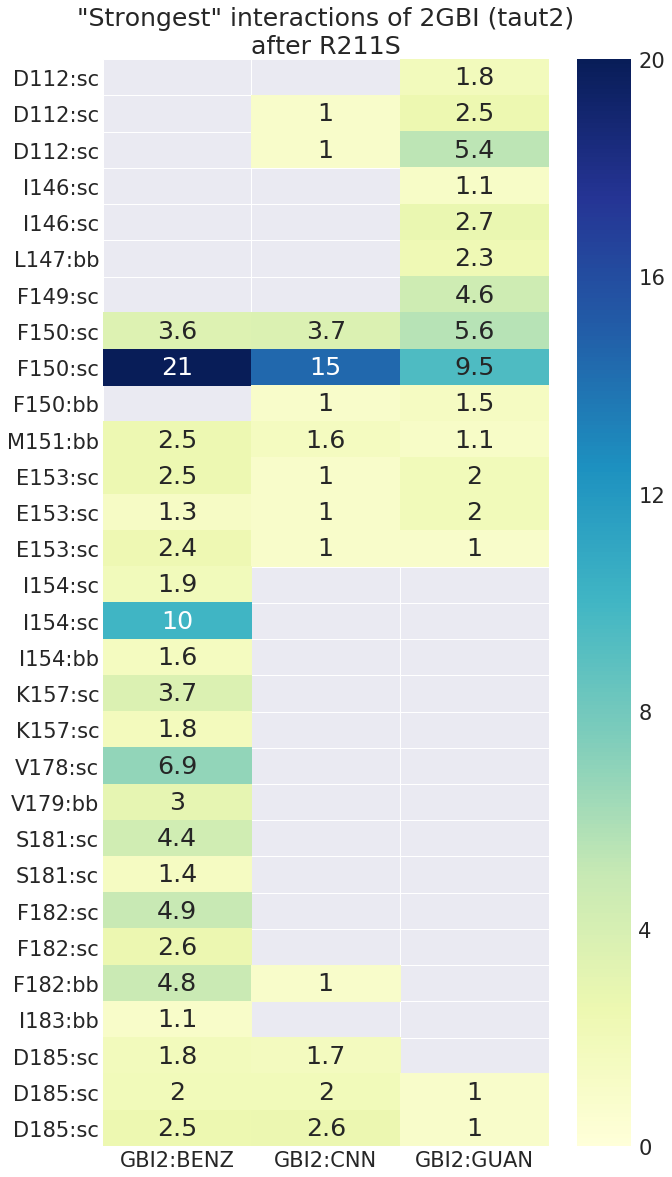

interaction range is from 0 to 20; verify if this is appropriate


In [30]:
# similarize edges before and after mutation
sim_mut_gbi2_edges, sim_wild_gbi2_edges = similarizeTwoEdges(mut_gbi2_edges, wild_gbi2_edges, mutstart=381, offset=1)
plotHeatInts(nodes_2,sim_mut_gbi2_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),
             seltitle='2GBI (taut2)\nafter {}'.format(mutcode))

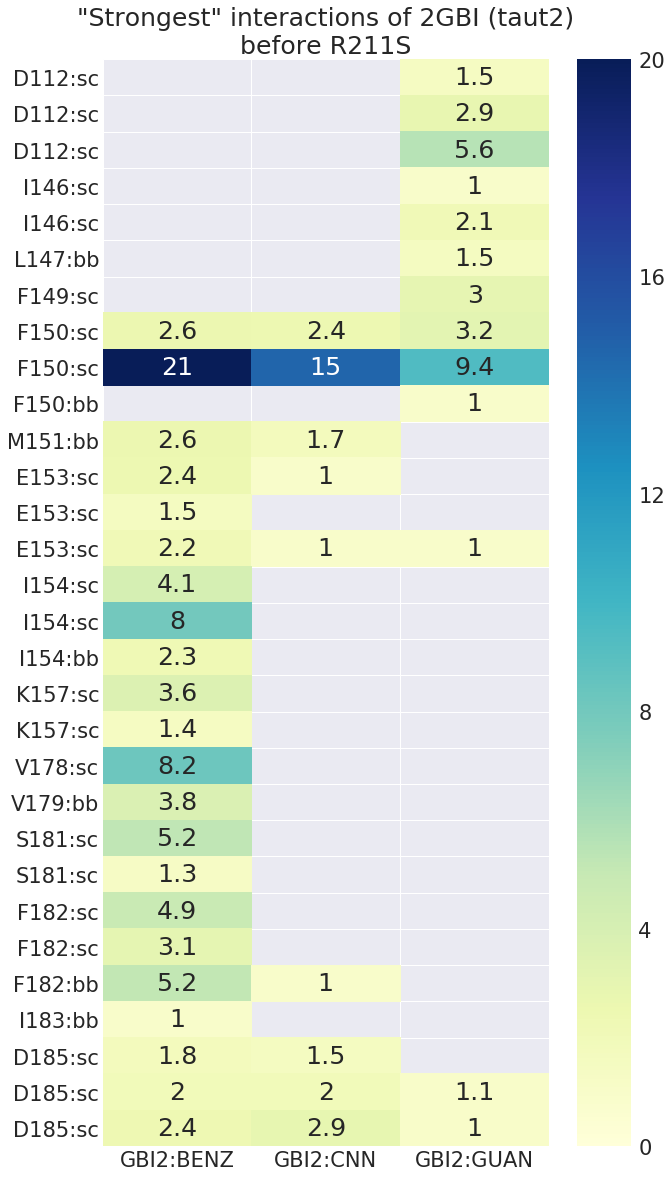

interaction range is from 0 to 20; verify if this is appropriate


In [31]:
plotHeatInts(wt_nodes_2,sim_wild_gbi2_edges,minHeat=0,maxHeat=20,colors="YlGnBu",size=(10,20),
             seltitle='2GBI (taut2)\nbefore {}'.format(mutcode))

### 3. No ligand

[placeholder]

## C. Focus on relative hydration by residue

### 1. Tautomer 1

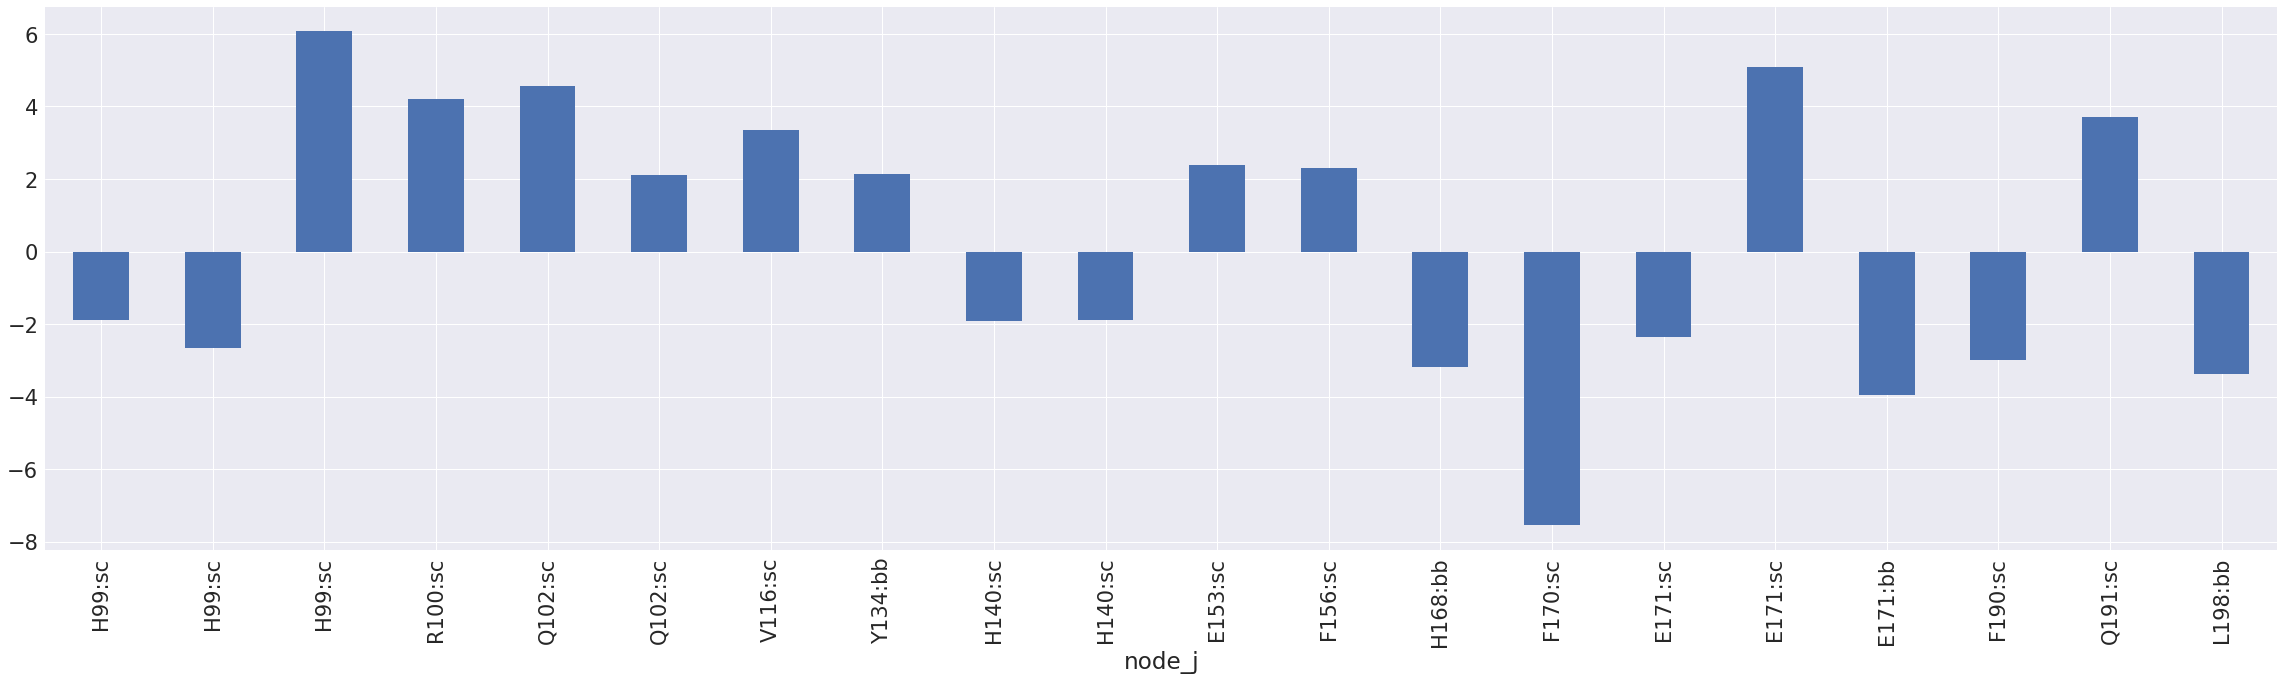

In [32]:
waterEdges_1 = plotBarWaters(dry_diff_nodes_1, dry_diff_edges_1)

### 2. Tautomer 2

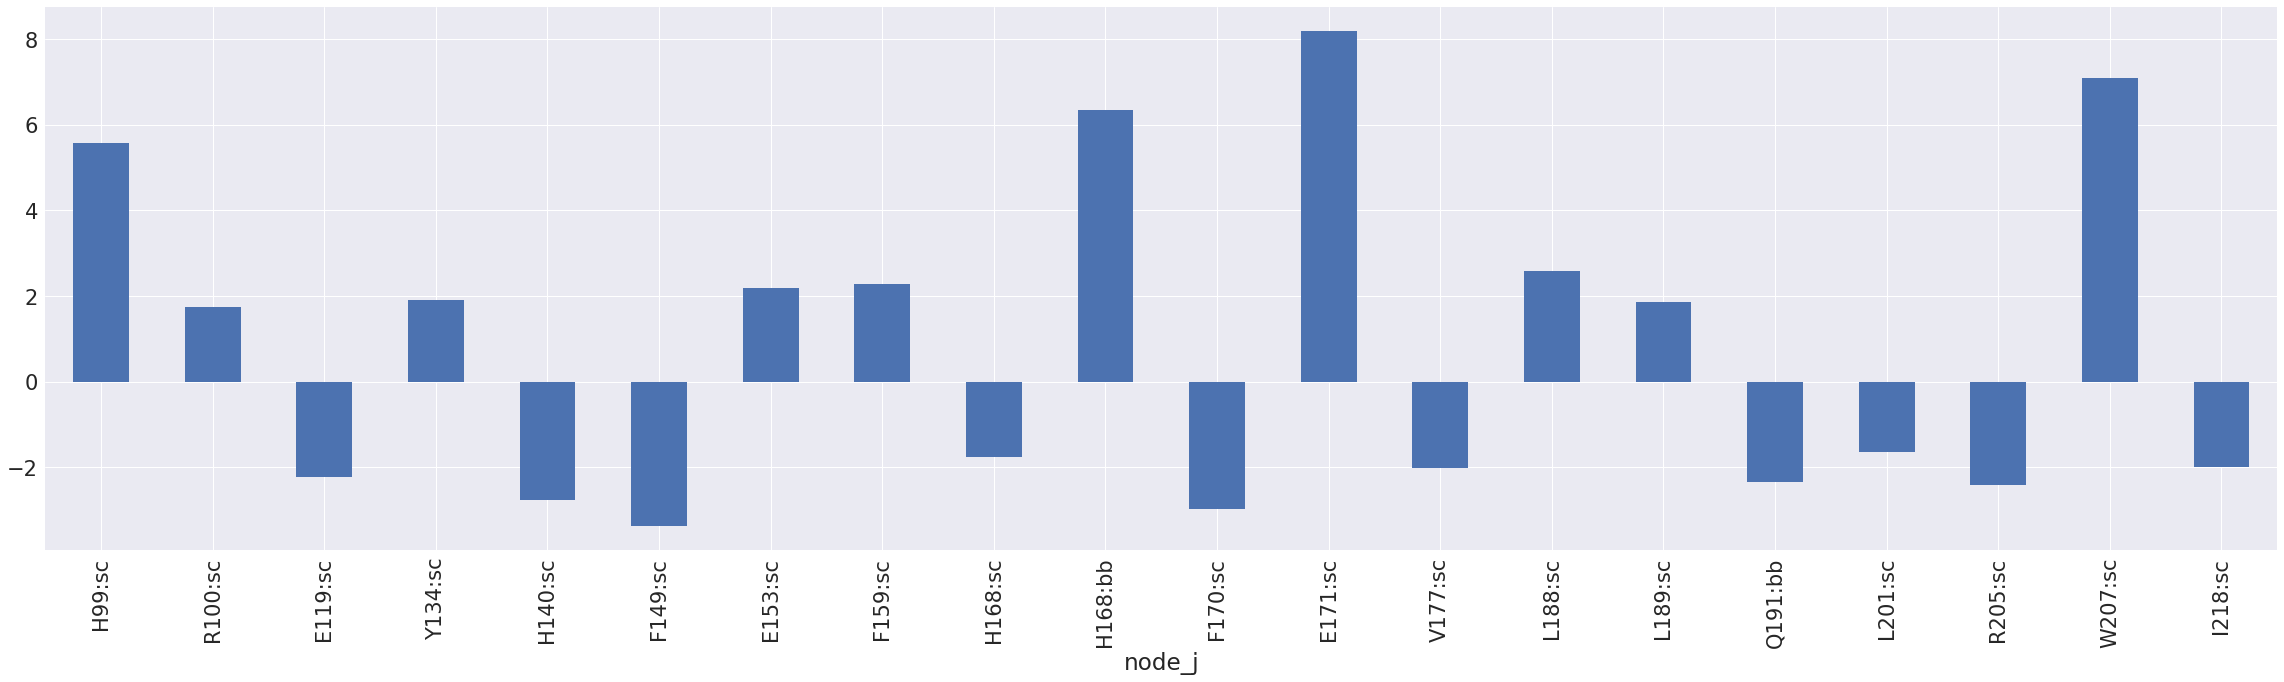

In [33]:
waterEdges_2 = plotBarWaters(dry_diff_nodes_2, dry_diff_edges_2)

### 3. Both tautomers in common

In [34]:
sim_waterEdges_1, sim_waterEdges_2 = similarizeTwoEdges(waterEdges_1, waterEdges_2)

node_i's in common:  []
node_j's in common:  [ 39  43 160 202 254 260 264]


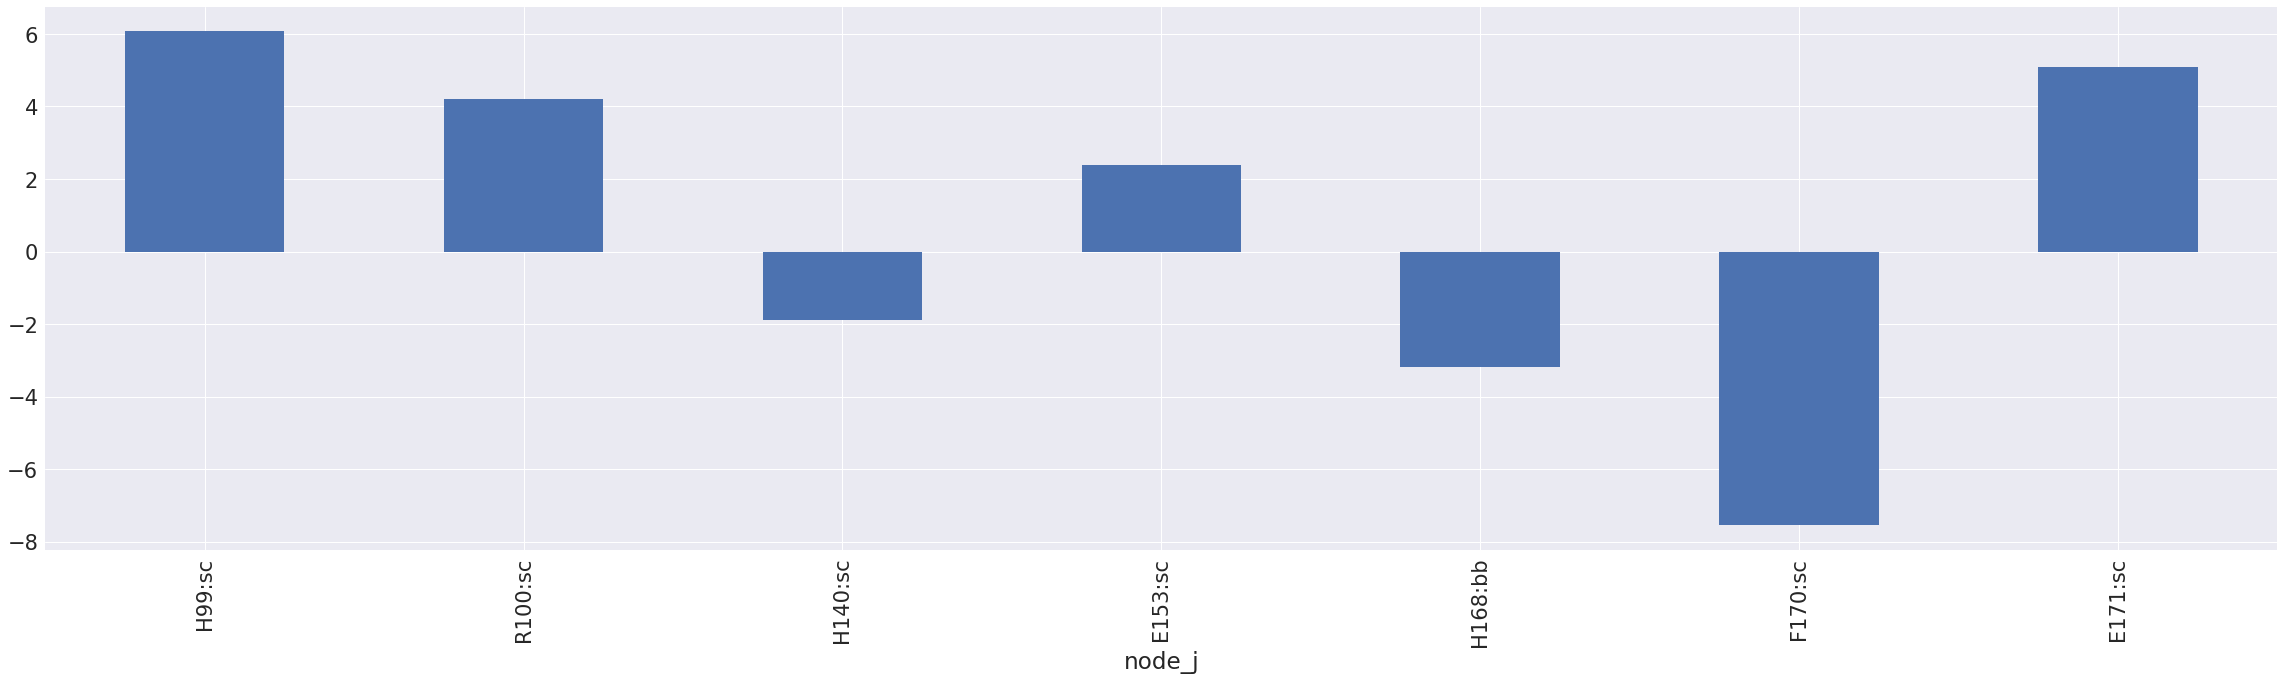

In [35]:
_ = plotBarWaters(dry_diff_nodes_1, sim_waterEdges_1, pivoted=True)

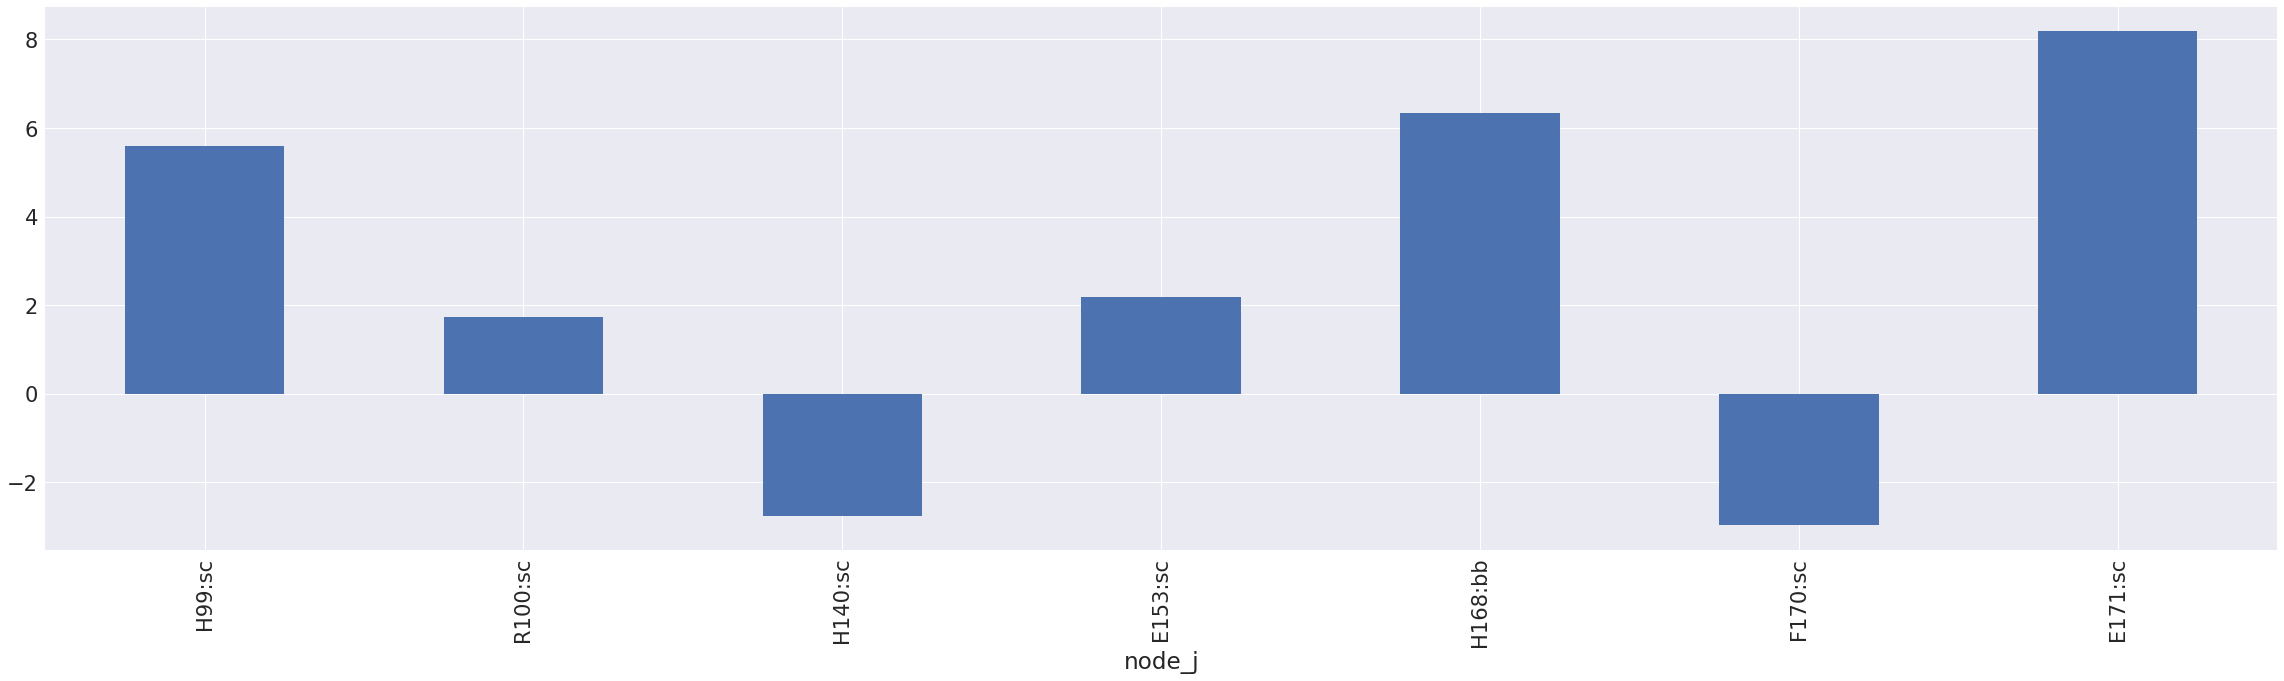

In [36]:
_ = plotBarWaters(dry_diff_nodes_2, sim_waterEdges_2, pivoted=True)

### 4. Verify hydration in edges
Verify that some residue does see the given change in water interactions.  
Not exact because the protein sidechain plotted in the heat map doesn't specify which node in residue.  
Fill in:
1. Node indices range, from getResidInfo (don't forget to add one to upper range)
2. Lower water index, from output of condenseWaters
3. Upper water index, from output of condenseWaters
4. 'average' or 'avg_subt'

In [37]:
getResidInfo(128,nodes_2,resExcludes=['WAT'])

,resname,resid,location,type,code,nAtoms
index,,,,,,
124,GLN,128,sc,NOP,ABG,3
125,GLN,128,sc,DIP,DE,3
126,GLN,128,bb,DIP,BB,3


In [38]:
diff_edges_2[(diff_edges_2.node_i.isin(range(124,127))) & (diff_edges_2.node_j>447) & (diff_edges_2.node_j<11227)].avg_subt.sum()

0.0

## D. Focus on other defined interactions

### 1. D112

In [39]:
# get and verify indices for after and before case (112 is before mutation)
selNodes_112 = getResidInfo(112, nodes_1, resExcludes=['WAT'])
d112idx_1 = selNodes_112.index.tolist()[:-1]
print(d112idx_1)
selNodes_112

[75, 76, 77]


,resname,resid,location,type,code,nAtoms
index,,,,,,
75,ASP,112,sc,NOP,AB,2
76,ASP,112,sc,NOP,G,1
77,ASP,112,sc,NEG,D,2
78,ASP,112,bb,DIP,BB,3


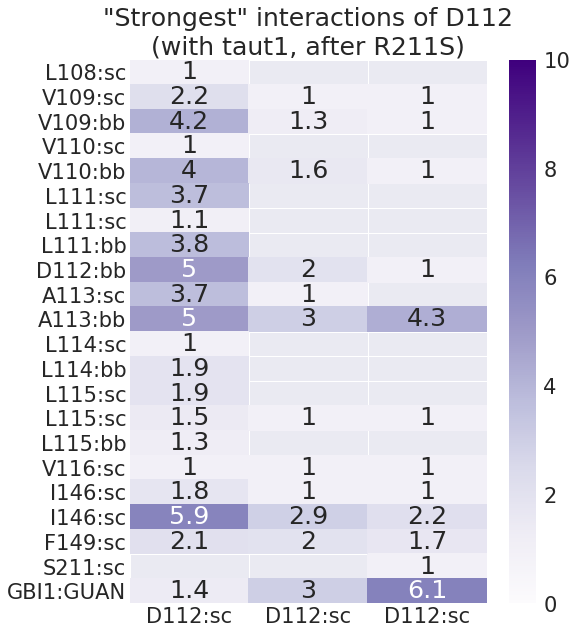

interaction range is from 0 to 10; verify if this is appropriate


node_j,65,68,69,70,71,72,73,74,78,79,...,83,84,85,86,87,180,181,189,382,11233
node_i,,,,,,,,,,,,,,,,,,,,,
75,1.0,2.211155,4.195219,1.015152,4.000000,3.737052,1.08642,3.780876,5.000000,3.729084,...,1.89243,1.944223,1.477064,1.252252,1.0,1.825532,5.948207,2.075117,NaN,1.375000
76,NaN,1.006579,1.276316,NaN,1.621212,NaN,NaN,NaN,2.000000,1.004049,...,NaN,NaN,1.000000,NaN,1.0,1.000000,2.940239,2.000000,NaN,3.000000
77,NaN,1.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,1.007968,NaN,...,NaN,NaN,1.000000,NaN,1.0,1.000000,2.179283,1.693989,1.0,6.051793


In [40]:
# d112 after mutation
mut1_d112_edges = selectionInts(nodes_1, edges_1, d112idx_1, rawNum=200)
plotHeatInts(nodes_1,mut1_d112_edges,minHeat=0,maxHeat=10,colors="Purples",size=(8,10),
             seltitle='D112\n(with taut1, after {})'.format(mutcode))
mut1_d112_edges

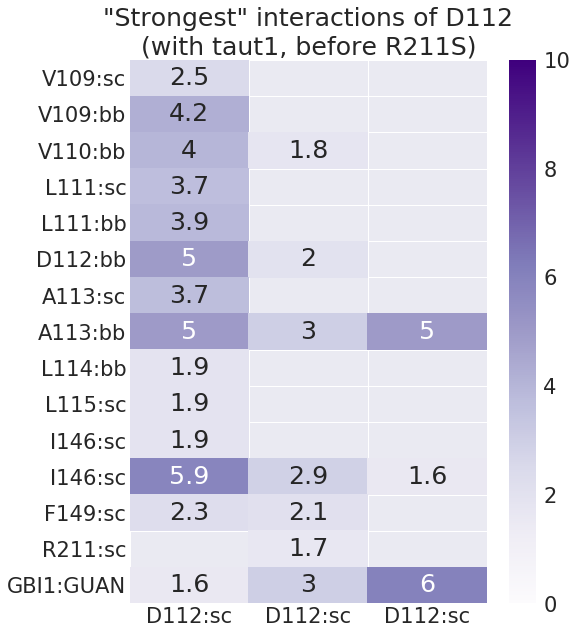

interaction range is from 0 to 10; verify if this is appropriate


node_j,68,69,71,72,74,78,79,80,83,84,180,181,189,383,11234
node_i,,,,,,,,,,,,,,,
75,2.468,4.24,4.000000,3.672,3.9,4.996,3.736,5.000,1.9,1.932,1.881857,5.916,2.302041,NaN,1.580488
76,NaN,NaN,1.799087,NaN,NaN,2.000,NaN,3.000,NaN,NaN,NaN,2.912,2.095833,1.666667,3.000000
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.032,NaN,NaN,NaN,1.584,NaN,NaN,6.036000


In [41]:
# d112 before mutation
wt1_d112_edges = selectionInts(wt_nodes_1, wt_edges_1, d112idx_1, rawNum=25)
plotHeatInts(wt_nodes_1,wt1_d112_edges,minHeat=0,maxHeat=10,colors="Purples",size=(8,10),
             seltitle='D112\n(with taut1, before {})'.format(mutcode))
wt1_d112_edges

In [42]:
# get and verify indices for diff
diff_selNodes_112 = getResidInfo(112, diff_nodes_1, resExcludes=['WAT'])
diff_d112idx_1 = selNodes_112.index.tolist()[:-1]
print(diff_d112idx_1)
diff_selNodes_112

[75, 76, 77]


,resname,resid,location,type,code,nAtoms
index,,,,,,
75,ASP,112,sc,NOP,AB,2
76,ASP,112,sc,NOP,G,1
77,ASP,112,sc,NEG,D,2
78,ASP,112,bb,DIP,BB,3


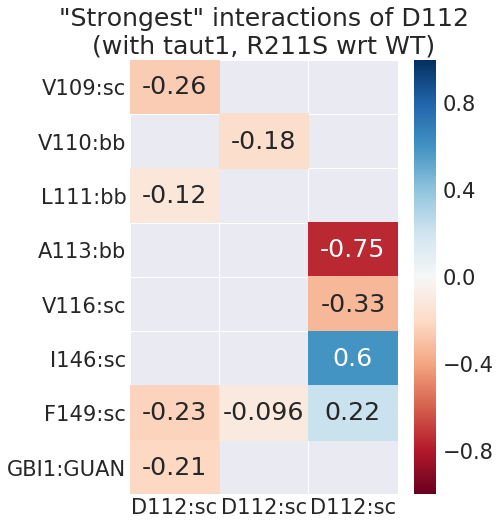

interaction range is from -1 to 1; verify if this is appropriate


node_j,68,71,74,80,87,181,189,11234
node_i,,,,,,,,
75,-0.256845,NaN,-0.119124,NaN,NaN,NaN,-0.226923,-0.205488
76,NaN,-0.177875,NaN,NaN,NaN,NaN,-0.095833,NaN
77,NaN,NaN,NaN,-0.753116,-0.333333,0.595283,0.219413,NaN


In [43]:
# d112 analysis (after-before) mutation
pivot1_diff_d112_edges = selectionInts(dry_diff_nodes_1, dry_diff_edges_1, diff_d112idx_1, rawNum=10)
plotHeatInts(dry_diff_nodes_1,pivot1_diff_d112_edges,minHeat=-1,maxHeat=1,colors="RdBu",size=(6,8),
             seltitle='D112\n(with taut1, {} wrt WT)'.format(mutcode))
pivot1_diff_d112_edges

### 2. D185

In [44]:
# get and verify indices for after and before case (185 is before mutation)
selNodes_185 = getResidInfo(185, nodes_1, resExcludes=['WAT'])
d185idx_1 = selNodes_185.index.tolist()[:-1]
print(d185idx_1)
selNodes_185

[300, 301, 302]


,resname,resid,location,type,code,nAtoms
index,,,,,,
300,ASP,185,sc,NOP,AB,2
301,ASP,185,sc,NOP,G,1
302,ASP,185,sc,NEG,D,2
303,ASP,185,bb,DIP,BB,3


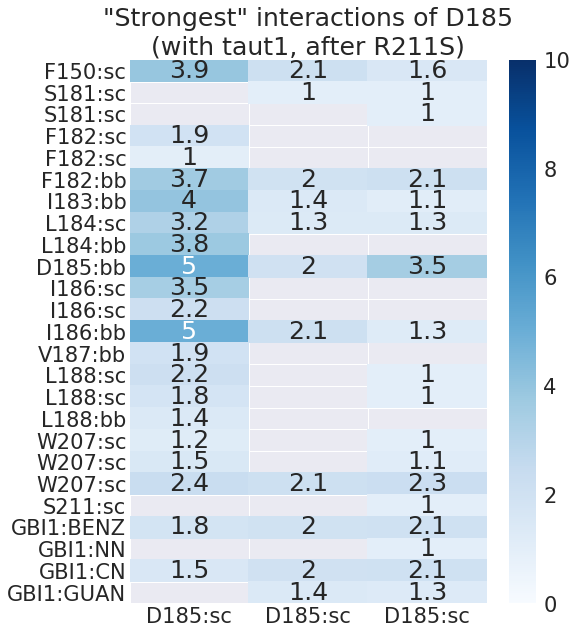

interaction range is from 0 to 10; verify if this is appropriate


node_j,192,288,289,291,292,293,296,297,299,303,...,310,311,369,370,371,382,11230,11231,11232,11233
node_i,,,,,,,,,,,,,,,,,,,,,
300,3.927711,NaN,NaN,1.948207,1.022222,3.663968,4.000000,3.215139,3.792829,5.000000,...,1.794286,1.417582,1.196721,1.485597,2.364444,NaN,1.810945,NaN,1.540404,NaN
301,2.113636,1.0,NaN,NaN,NaN,1.988048,1.444976,1.340909,NaN,2.015936,...,NaN,NaN,NaN,NaN,2.119522,NaN,1.968127,NaN,1.996016,1.428571
302,1.560345,1.0,1.0,NaN,NaN,2.132000,1.100000,1.333333,NaN,3.525896,...,1.000000,NaN,1.000000,1.135458,2.262948,1.0,2.063745,1.0,2.063745,1.326531


In [45]:
# d185 after mutation
mut1_d185_edges = selectionInts(nodes_1, edges_1, d185idx_1, rawNum=50)
plotHeatInts(nodes_1,mut1_d185_edges,minHeat=0,maxHeat=10,colors="Blues",size=(8,10),
             seltitle='D185\n(with taut1, after {})'.format(mutcode))
mut1_d185_edges

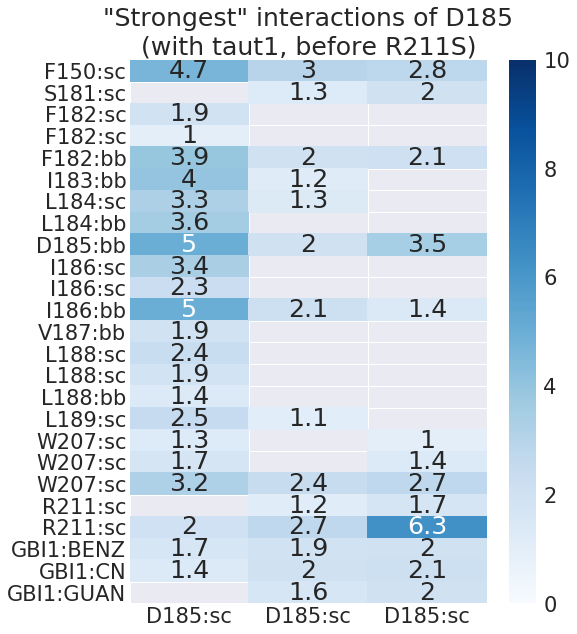

interaction range is from 0 to 10; verify if this is appropriate


node_j,192,288,291,292,293,296,297,299,303,304,...,311,313,369,370,371,382,383,11231,11233,11234
node_i,,,,,,,,,,,,,,,,,,,,,
300,4.680000,NaN,1.915663,1.032258,3.912000,4.000000,3.284000,3.56,5.000,3.364,...,1.376884,2.513699,1.324,1.708,3.218884,NaN,2.031579,1.673611,1.370079,NaN
301,2.983740,1.307692,NaN,NaN,2.000000,1.220588,1.329545,NaN,2.012,NaN,...,NaN,1.100000,NaN,NaN,2.408000,1.156,2.716000,1.936000,2.000000,1.60241
302,2.781991,2.000000,NaN,NaN,2.080972,NaN,NaN,NaN,3.512,NaN,...,NaN,NaN,1.008,1.372,2.704000,1.740,6.288000,1.960000,2.116000,1.95600


In [46]:
# d185 before mutation
wt1_d185_edges = selectionInts(wt_nodes_1, wt_edges_1, d185idx_1, rawNum=50)
plotHeatInts(wt_nodes_1,wt1_d185_edges,minHeat=0,maxHeat=10,colors="Blues",size=(8,10),
             seltitle='D185\n(with taut1, before {})'.format(mutcode))
wt1_d185_edges

In [47]:
# get and verify indices for diff
diff_selNodes_185 = getResidInfo(185, diff_nodes_1, resExcludes=['WAT'])
diff_d185idx_1 = selNodes_185.index.tolist()[:-1]
print(diff_d185idx_1)
diff_selNodes_185

[300, 301, 302]


,resname,resid,location,type,code,nAtoms
index,,,,,,
300,ASP,185,sc,NOP,AB,2
301,ASP,185,sc,NOP,G,1
302,ASP,185,sc,NEG,D,2
303,ASP,185,bb,DIP,BB,3


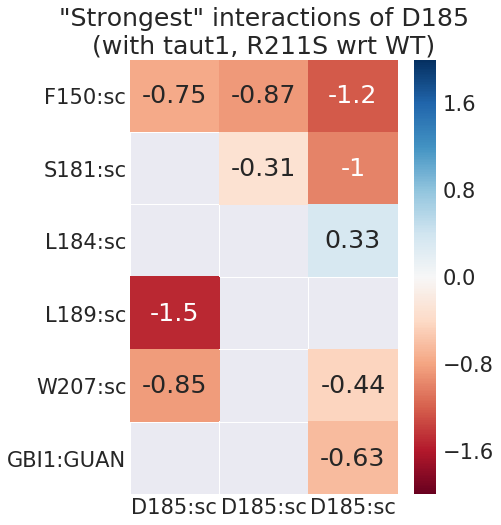

interaction range is from -2 to 2; verify if this is appropriate


node_j,192,288,297,313,371,11234
node_i,,,,,,
300,-0.752289,NaN,NaN,-1.513699,-0.854440,NaN
301,-0.870103,-0.307692,NaN,NaN,NaN,NaN
302,-1.221646,-1.000000,0.333333,NaN,-0.441052,-0.629469


In [48]:
# d185 analysis (after-before) mutation
pivot1_diff_d185_edges = selectionInts(dry_diff_nodes_1, dry_diff_edges_1, diff_d185idx_1, rawNum=10)
plotHeatInts(dry_diff_nodes_1,pivot1_diff_d185_edges,minHeat=-2,maxHeat=2,colors="RdBu",size=(6,8),
             seltitle='D185\n(with taut1, {} wrt WT)'.format(mutcode))
pivot1_diff_d185_edges

### 3. R211

In [49]:
# get and verify indices for AFTER
selNodes_211 = getResidInfo(211, nodes_1, resExcludes=['WAT'])
r211idx_1 = selNodes_211.index.tolist()[:-1]
print(r211idx_1)
selNodes_211

[381, 382]


,resname,resid,location,type,code,nAtoms
index,,,,,,
381,SER,211,sc,NOP,AB,2
382,SER,211,sc,DIP,G,1
383,SER,211,bb,DIP,BB,3


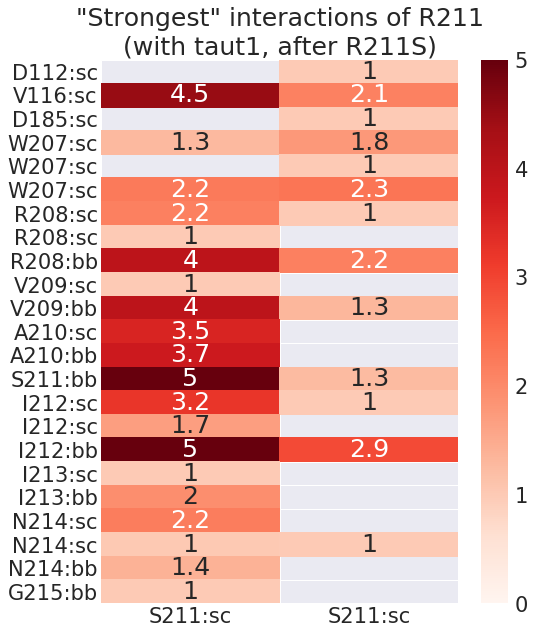

interaction range is from 0 to 5; verify if this is appropriate


node_j,77,87,302,369,370,371,373,374,376,377,...,383,384,385,386,387,389,390,391,392,394
node_i,,,,,,,,,,,,,,,,,,,,,
381,NaN,4.498008,NaN,1.285714,NaN,2.250000,2.155378,1.0,3.996016,1.0,...,5.000000,3.231076,1.692982,5.000000,1.0,1.952191,2.195219,1.03125,1.396104,1.0
382,1.0,2.143519,1.0,1.792453,1.0,2.333333,1.000000,NaN,2.153061,NaN,...,1.266932,1.000000,NaN,2.920319,NaN,NaN,NaN,1.00000,NaN,NaN


In [50]:
# r211 after mutation
mut1_r211_edges = selectionInts(nodes_1, edges_1, r211idx_1, rawNum=200)
plotHeatInts(nodes_1,mut1_r211_edges,minHeat=0,maxHeat=5,colors="Reds",size=(8,10),
             seltitle='R211\n(with taut1, after {})'.format(mutcode))
mut1_r211_edges

In [51]:
# get and verify indices for BEFORE
selNodes_211 = getResidInfo(211, wt_nodes_1, resExcludes=['WAT'])
r211idx_1 = selNodes_211.index.tolist()[:-1]
print(r211idx_1)
selNodes_211

[381, 382, 383]


,resname,resid,location,type,code,nAtoms
index,,,,,,
381,ARG,211,sc,NOP,AB,2
382,ARG,211,sc,NOP,GD,2
383,ARG,211,sc,POS,EZ,4
384,ARG,211,bb,DIP,BB,3


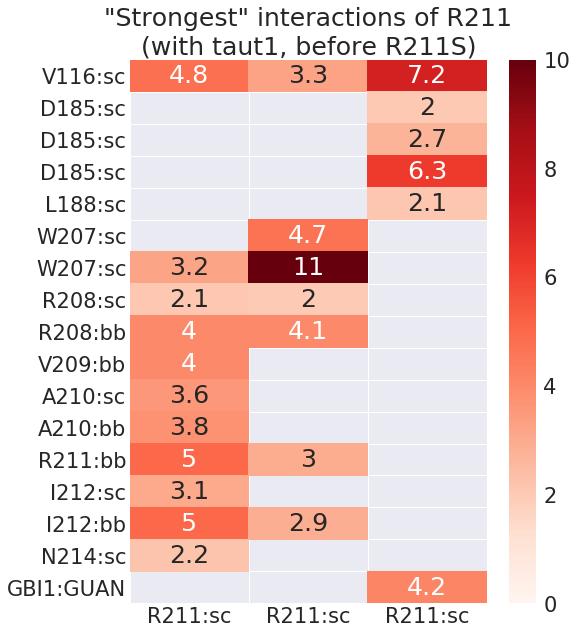

interaction range is from 0 to 10; verify if this is appropriate


node_j,87,300,301,302,310,369,371,373,376,378,379,380,384,385,387,391,11234
node_i,,,,,,,,,,,,,,,,,
381,4.828000,NaN,NaN,NaN,NaN,NaN,3.215686,2.088000,4.000,4.0,3.576,3.776,5.000,3.072,5.0,2.2,NaN
382,3.269076,NaN,NaN,NaN,NaN,4.7,11.312000,2.012146,4.052,NaN,NaN,NaN,2.964,NaN,2.9,NaN,NaN
383,7.208000,2.031579,2.716,6.288,2.116466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.169355


In [52]:
# r211 before mutation
wt1_r211_edges = selectionInts(wt_nodes_1, wt_edges_1, r211idx_1, rawNum=25)
plotHeatInts(wt_nodes_1,wt1_r211_edges,minHeat=0,maxHeat=10,colors="Reds",size=(8,10),
             seltitle='R211\n(with taut1, before {})'.format(mutcode))
wt1_r211_edges

# III. Analyze interactions differentiating tautomers

Protein + ligand interactions, with respect to tautomer 1.

## A. Focus on whole protein-ligand system

### 1. After mutation

nodes in 1st, not in 2nd:  [11227 11228 11229 11230 11231 11232 11233]
nodes in 2nd, not in 1st:  [11227 11228 11229]
Shifting node indices by 4 for 0 rows


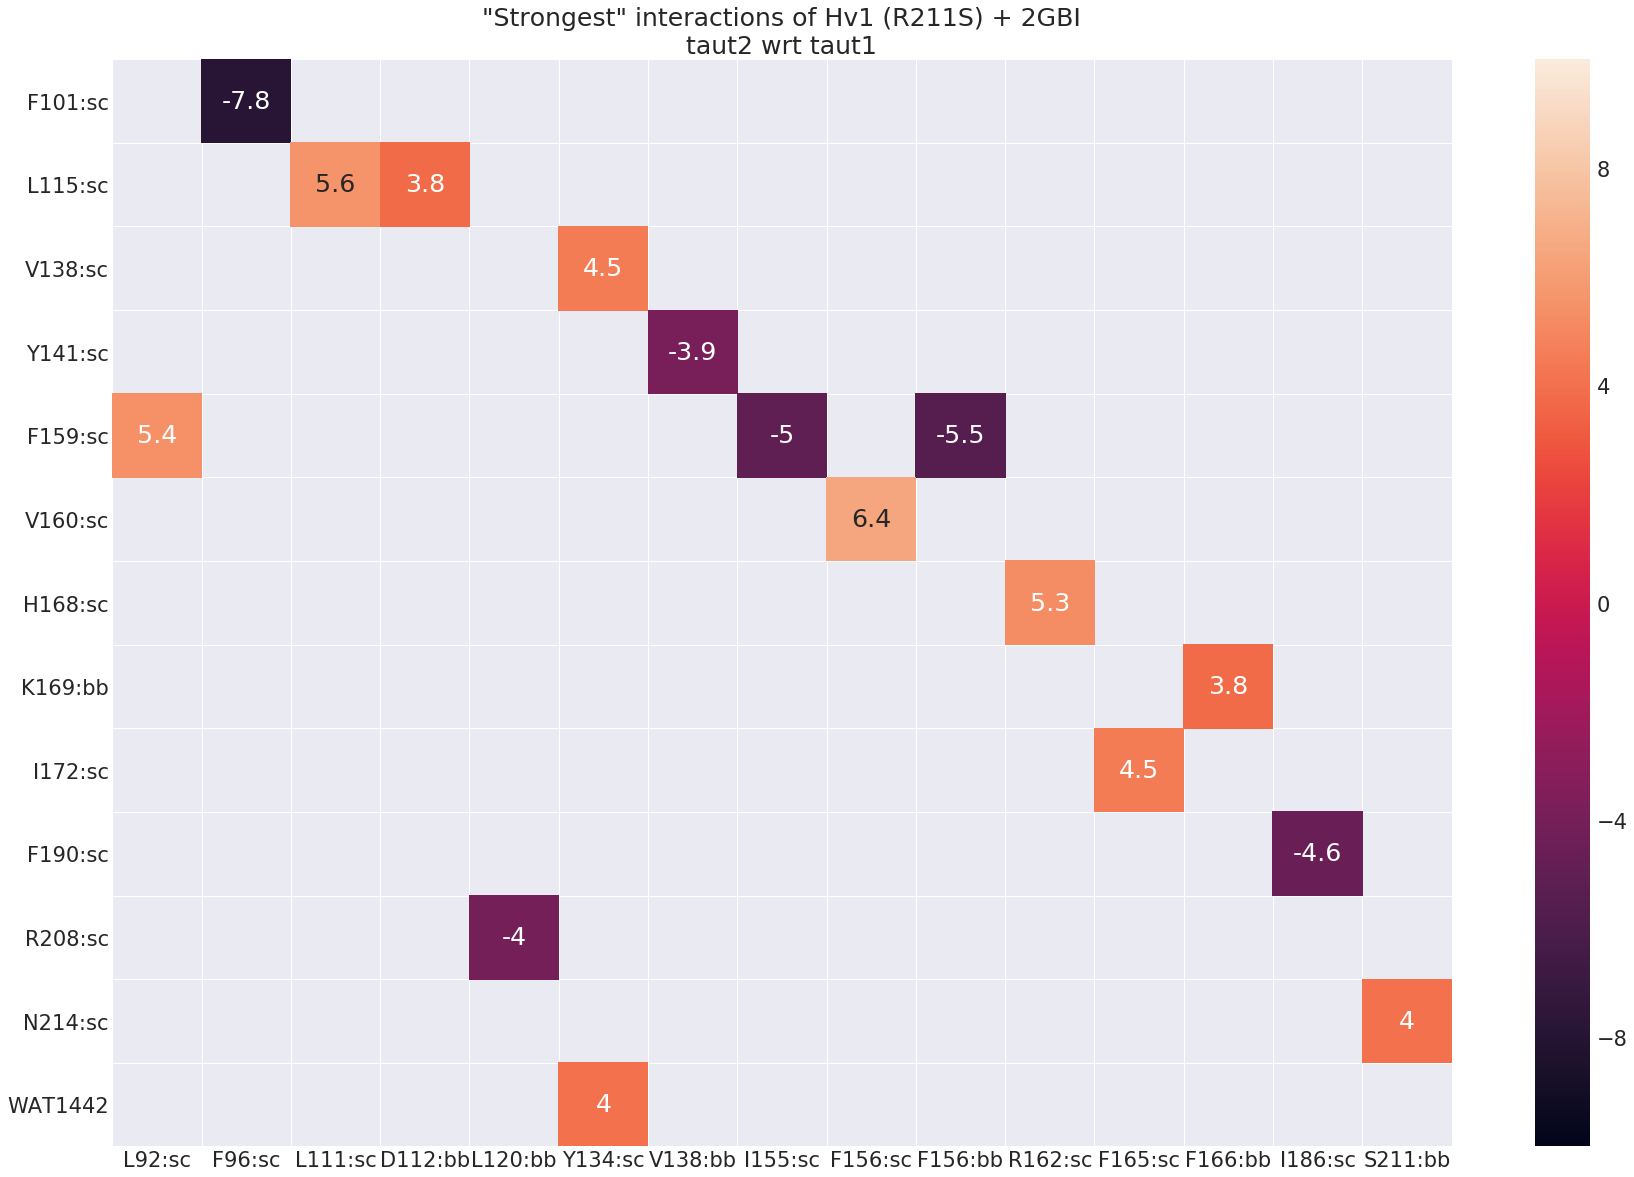

interaction range is from -10 to 10; verify if this is appropriate


In [53]:
diff_nodes_21, diff_edges_21, mutstart_21, offset_21 = diffEdges(nodes_2,nodes_1,edges_2,edges_1)
watless_diff_edges_21 = protLigInts(diff_nodes_21, diff_edges_21,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_21, watless_diff_edges_21, minHeat=-10, maxHeat=10, size=(30,20),
             seltitle="Hv1 ({}) + 2GBI\ntaut2 wrt taut1".format(mutcode))

nodes in 1st, not in 2nd:  [11230 11231 11232 11233]
nodes in 2nd, not in 1st:  [11230 11231 11232 11233]
Shifting node indices by 0 for 0 rows


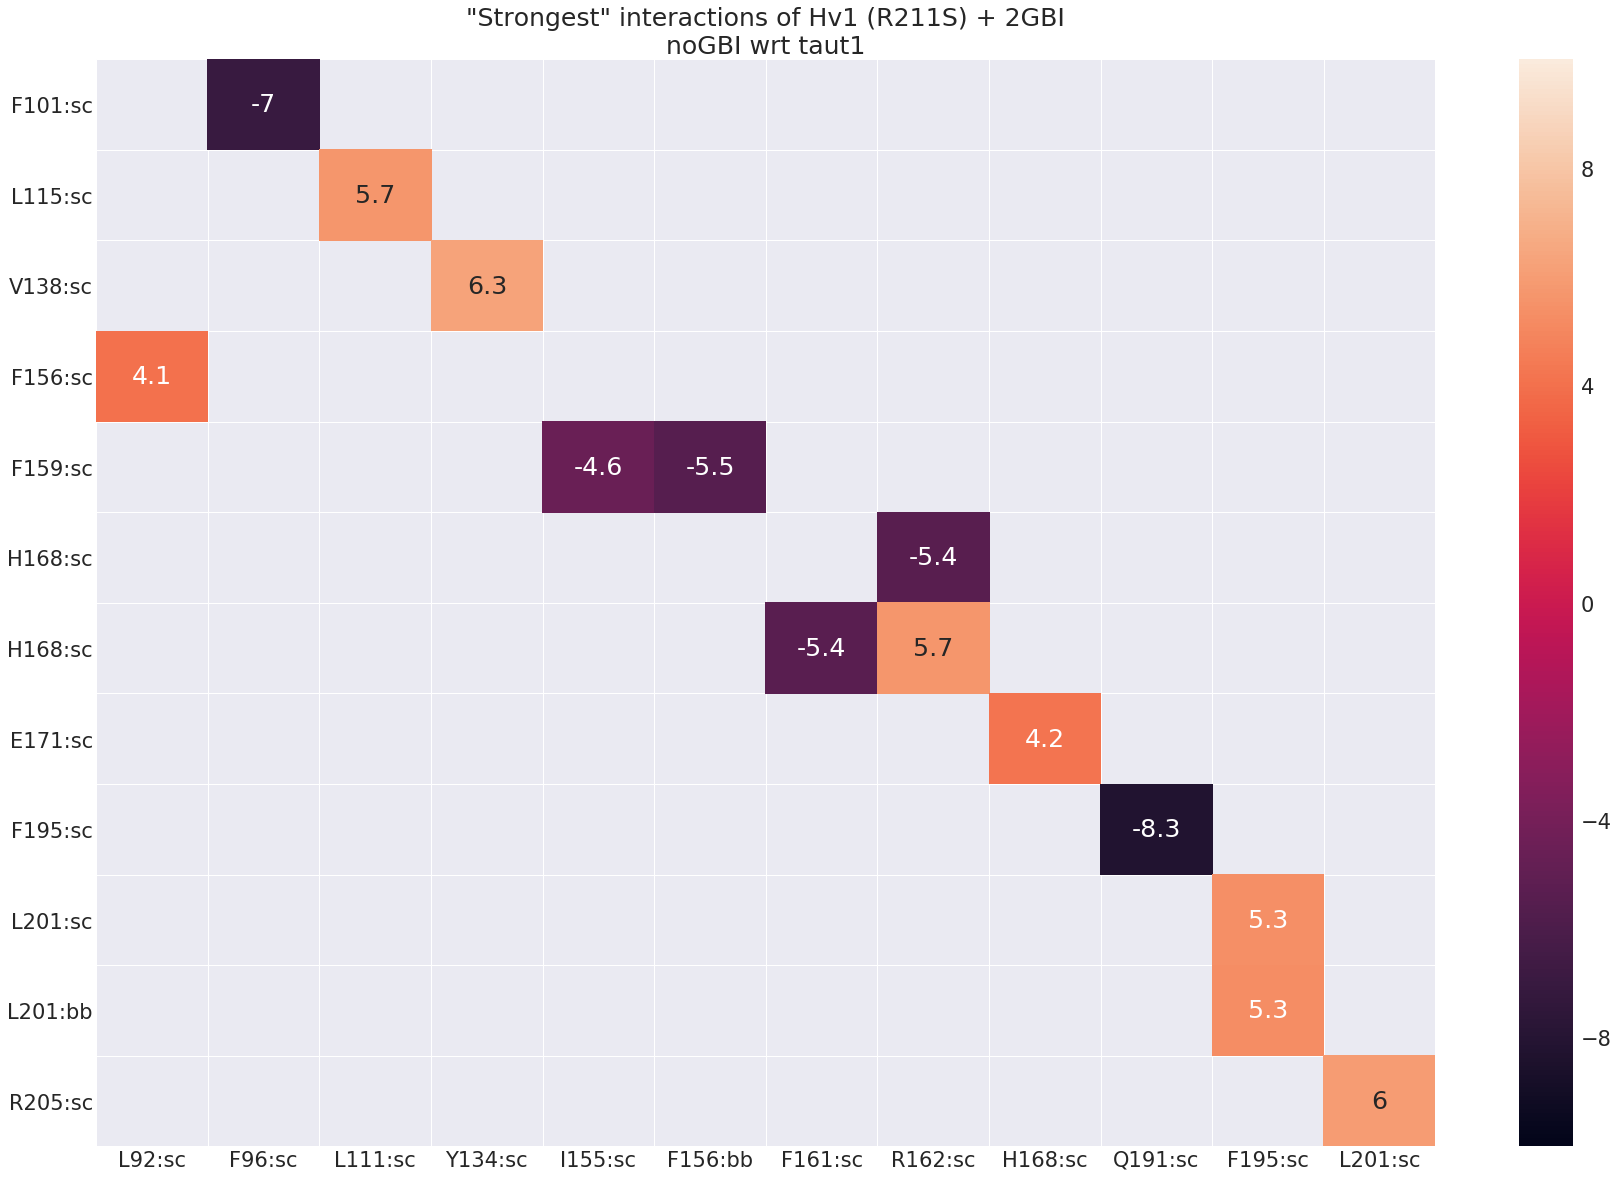

interaction range is from -10 to 10; verify if this is appropriate


In [54]:
diff_nodes_01, diff_edges_01, mutstart_01, offset_01 = diffEdges(nodes_0,nodes_1,edges_0,edges_1)
watless_diff_edges_01 = protLigInts(diff_nodes_01, diff_edges_01,rawNum=25) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_01, watless_diff_edges_01, minHeat=-10, maxHeat=10, size=(30,20),
             seltitle="Hv1 ({}) + 2GBI\nnoGBI wrt taut1".format(mutcode))

### 2. Before mutation

[placeholder]

## B. Focus on ligand-specific interactions

### 1. After mutation

[placeholder]

### 2. Before mutation

[placeholder]

# IV. Analyze differences wrt thermodynamic cycle

![thermodynamic_cycle](https://cdn.pbrd.co/images/HaKJ6fc8.png)

For oval as wild-type protein and rectangle as the mutant, the relative binding free energies are calculated as:  
$$\Delta \Delta G = \Delta G_4 - \Delta G_3$$  
(The $\Delta G_1$ and $\Delta G_2$ are the corresponding experimental measurements.)  


In this section of the notebook, compute interaction differences in a roughly analogous manner.  
For example, for the RBFE for the D112E mutation with tautomer 1 of 2GBI:
1. ($\Delta G_4$) Take `edges_e112_taut1` minus `edges_d112_taut1`.  
    This represents the changes in interaction with the ligand present, from before and after mutation.
2. ($\Delta G_3$) Take `edges_e112_noGBI` minus `edges_d112_noGBI`.  
    This represents the changes in interaction _without_ the ligand present, from before and after mutation.
3. Take edges of step 1 minus edges of step 2 to get final set of edges.

**Rationale:**  
* If the mutation causes similar changes in the system with and without the ligand present, that may not be as significant a contributor to the RBFE. However, if there is a change that happens in only one or the other leg of the cycle, that could help pinpoint interactions to qualitatively explain the binding energy.  
* Obviously the 2GBI ligand will not be in the final set of edges because it's not in the `noGBI` case. However, there may be some rearrangements in the residues involved in binding or close to the mutation.
* Output means something along the lines of: interaction strength of 2GBI system, after subtracting interaction strength of noGBI system.

## Tautomer 1

In [55]:
diff_nodes_10, diff_edges_10, mutstart_10, offset_10 = diffdiffEdges(dry_diff_nodes_1,dry_diff_nodes_0,dry_diff_edges_1,dry_diff_edges_0)

nodes in 1st, not in 2nd:  [11227 11228 11229 11230]
nodes in 2nd, not in 1st:  [11227 11228 11229 11230]
Shifting node indices by 0 for 502 rows


../nodeAnalysis.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_change_i['node_i'] += offset
../nodeAnalysis.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_change_j['node_j'] += offset


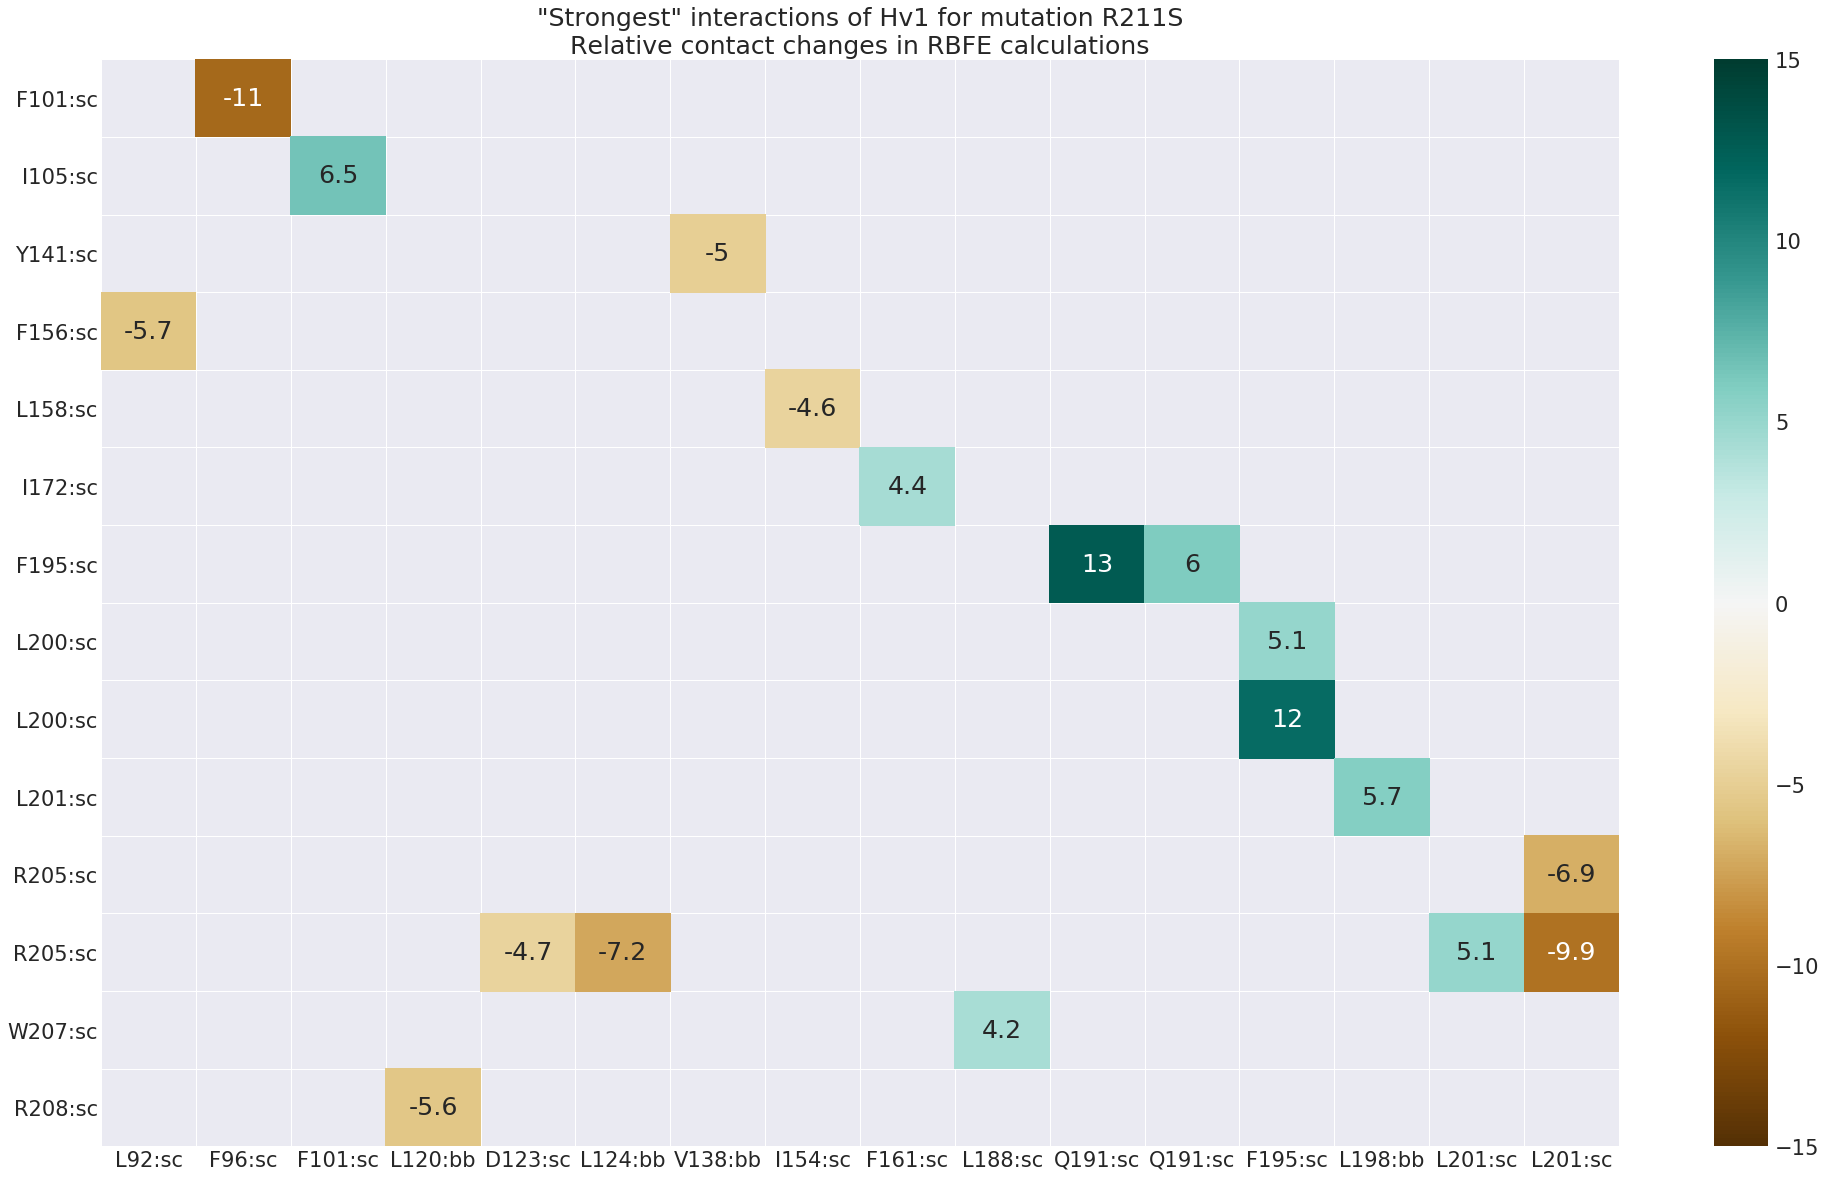

interaction range is from -15 to 15; verify if this is appropriate


In [56]:
pivot_diff_edges_10 = protLigInts(diff_nodes_10, diff_edges_10,dry=2,rawNum=20) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_10, pivot_diff_edges_10, minHeat=-15, maxHeat=15, colors="BrBG", size=(34,20),
             seltitle="Hv1 for mutation {}\nRelative contact changes in RBFE calculations".format(mutcode))

** Verify by looking at edge components **

In [57]:
getContactPair(201, 205, dry_diff_nodes_0, dry_diff_edges_0)

      resname resid location type code nAtoms
index                                        
350       LEU   201       sc  NOP   AB      2
351       LEU   201       sc  NOP   GD      3
352       LEU   201       bb  DIP   BB      3 

       resname resid location type code nAtoms
index                                        
362       ARG   205       sc  NOP   AB      2
363       ARG   205       sc  NOP   GD      2
364       ARG   205       sc  POS   EZ      4
365       ARG   205       bb  DIP   BB      3


,node_i,node_j,weight_x,attribute,count_x,average_x,weight_y,count_y,average_y,avg_subt
2621,350,362,3,HPHOB,3,1,2,2,1,0.000000
2622,350,363,409,HPHOB,178,2.29775,848,249,3.40562,-1.107870
2623,350,364,116,STER,116,1,1081,250,4.324,-3.324000
2624,350,365,4,STER,4,1,2,2,1,0.000000
2630,351,363,1216,HPHOB,251,4.84462,43,28,1.53571,3.308907
2631,351,364,2641,STER,251,10.5219,1430,248,5.76613,4.755783


In [58]:
getContactPair(201, 205, dry_diff_nodes_1, dry_diff_edges_1)

      resname resid location type code nAtoms
index                                        
350       LEU   201       sc  NOP   AB      2
351       LEU   201       sc  NOP   GD      3
352       LEU   201       bb  DIP   BB      3 

       resname resid location type code nAtoms
index                                        
362       ARG   205       sc  NOP   AB      2
363       ARG   205       sc  NOP   GD      2
364       ARG   205       sc  POS   EZ      4
365       ARG   205       bb  DIP   BB      3


,node_i,node_j,weight_x,attribute,count_x,average_x,weight_y,count_y,average_y,avg_subt
3151,350,362,3,HPHOB,3,1,2,2,1,0.000000
3152,350,363,530,HPHOB,233,2.27468,367,174,2.1092,0.165483
3153,350,364,705,STER,251,2.80876,65,65,1,1.808765
3158,351,363,43,HPHOB,37,1.16216,1184,250,4.736,-3.573838
3159,351,364,1098,STER,243,4.51852,2419,250,9.676,-5.157481


** Sum edges by type **

In [59]:
diff_edges_10.groupby('attribute')['avg_subt'].sum().reset_index()

,attribute,avg_subt
0,COUL,2.726772
1,HBOND,2.632738
2,HPHOB,4.195332
3,STER,16.502067


In [60]:
watidx = diff_nodes_10.index[diff_nodes_10['resname'] == 'WAT'].tolist()
temp = diff_edges_10.loc[~diff_edges_10['node_i'].isin(watidx) & ~diff_edges_10['node_j'].isin(watidx)]
temp.groupby('attribute')['avg_subt'].sum().reset_index()

,attribute,avg_subt
0,COUL,2.726772
1,HBOND,-12.045895
2,HPHOB,4.195332
3,STER,16.502067


## Tautomer 2

In [61]:
diff_nodes_20, diff_edges_20, mutstart_20, offset_20 = diffdiffEdges(dry_diff_nodes_2,dry_diff_nodes_0,dry_diff_edges_2,dry_diff_edges_0)

nodes in 1st, not in 2nd:  [11224 11225 11226 11227 11228 11229 11230]
nodes in 2nd, not in 1st:  [11224 11225 11226]
Shifting node indices by 4 for 492 rows


../nodeAnalysis.py:446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_change_i['node_i'] += offset
../nodeAnalysis.py:447: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  to_change_j['node_j'] += offset


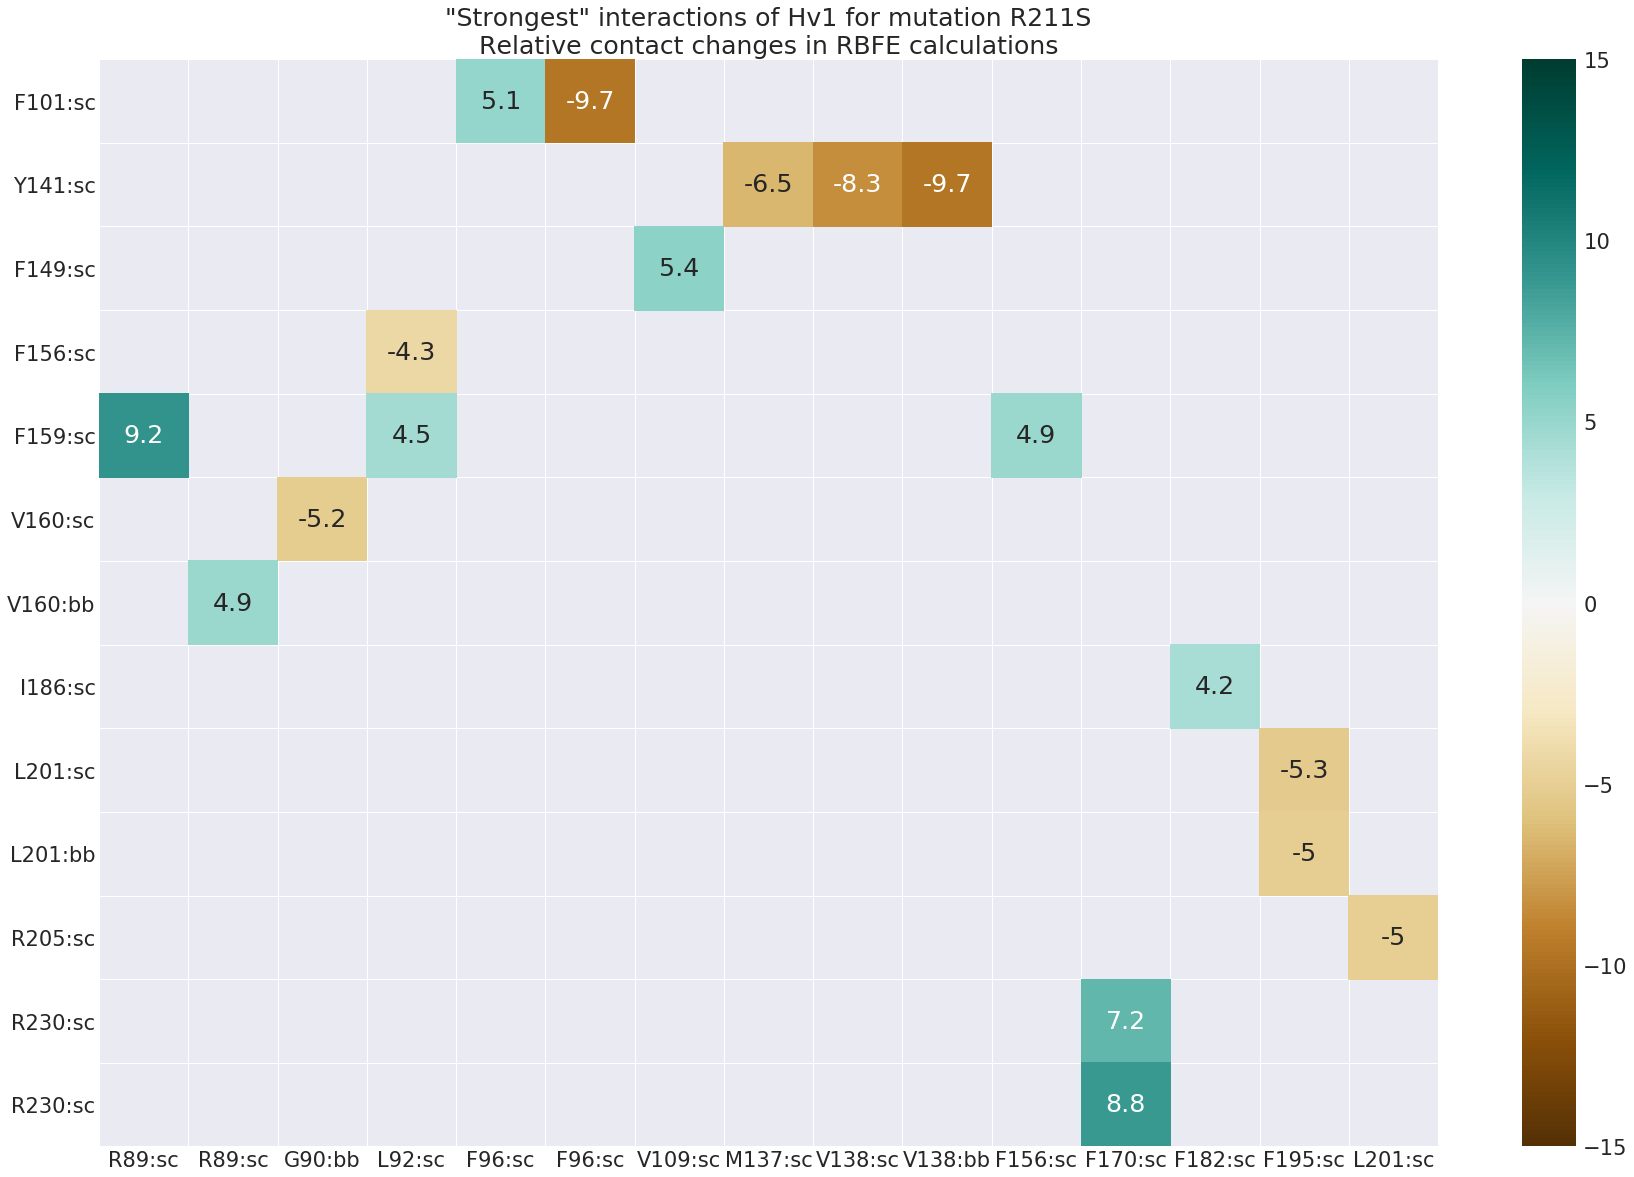

interaction range is from -15 to 15; verify if this is appropriate


In [62]:
pivot_diff_edges_20 = protLigInts(diff_nodes_20, diff_edges_20,dry=2,rawNum=20) # make sure you use REFERENCE nodes
plotHeatInts(diff_nodes_20, pivot_diff_edges_20, minHeat=-15, maxHeat=15, colors="BrBG", size=(30,20),
             seltitle="Hv1 for mutation {}\nRelative contact changes in RBFE calculations".format(mutcode))

** Verify by looking at edge components **

In [63]:
getContactPair(201, 205, dry_diff_nodes_0, dry_diff_edges_0)

      resname resid location type code nAtoms
index                                        
350       LEU   201       sc  NOP   AB      2
351       LEU   201       sc  NOP   GD      3
352       LEU   201       bb  DIP   BB      3 

       resname resid location type code nAtoms
index                                        
362       ARG   205       sc  NOP   AB      2
363       ARG   205       sc  NOP   GD      2
364       ARG   205       sc  POS   EZ      4
365       ARG   205       bb  DIP   BB      3


,node_i,node_j,weight_x,attribute,count_x,average_x,weight_y,count_y,average_y,avg_subt
2621,350,362,3,HPHOB,3,1,2,2,1,0.000000
2622,350,363,409,HPHOB,178,2.29775,848,249,3.40562,-1.107870
2623,350,364,116,STER,116,1,1081,250,4.324,-3.324000
2624,350,365,4,STER,4,1,2,2,1,0.000000
2630,351,363,1216,HPHOB,251,4.84462,43,28,1.53571,3.308907
2631,351,364,2641,STER,251,10.5219,1430,248,5.76613,4.755783


In [64]:
getContactPair(201, 205, dry_diff_nodes_2, dry_diff_edges_2)

      resname resid location type code nAtoms
index                                        
350       LEU   201       sc  NOP   AB      2
351       LEU   201       sc  NOP   GD      3
352       LEU   201       bb  DIP   BB      3 

       resname resid location type code nAtoms
index                                        
362       ARG   205       sc  NOP   AB      2
363       ARG   205       sc  NOP   GD      2
364       ARG   205       sc  POS   EZ      4
365       ARG   205       bb  DIP   BB      3


,node_i,node_j,weight_x,attribute,count_x,average_x,weight_y,count_y,average_y,avg_subt
3243,350,362,9,HPHOB,9,1,4,4,1,0.000000
3244,350,363,883,HPHOB,249,3.54618,884,247,3.57895,-0.032763
3245,350,364,1141,STER,251,4.54582,1119,250,4.476,0.069817
3251,351,363,40,HPHOB,27,1.48148,58,37,1.56757,-0.086086
3252,351,364,1441,STER,250,5.764,1494,248,6.02419,-0.260194


** Sum edges by type **

In [65]:
diff_edges_20.groupby('attribute')['avg_subt'].sum().reset_index()

,attribute,avg_subt
0,COUL,1.749889
1,HBOND,36.571828
2,HPHOB,51.294729
3,STER,6.105075


In [66]:
watidx = diff_nodes_20.index[diff_nodes_20['resname'] == 'WAT'].tolist()
temp = diff_edges_20.loc[~diff_edges_20['node_i'].isin(watidx) & ~diff_edges_20['node_j'].isin(watidx)]
temp.groupby('attribute')['avg_subt'].sum().reset_index()

,attribute,avg_subt
0,COUL,1.749889
1,HBOND,1.020556
2,HPHOB,51.294729
3,STER,6.105075


# V. Analyze interactions directly from computed edges

In other words, absolute interactions not with respect to anything.  
NOTE: Right now, I'm not sure how to interpret these heat maps well or how to make them more useful.

## A. Focus on whole protein-ligand system

### 1. After mutation

#### a. Tautomer 1

In [ ]:
# taut1
#pivot_edges_1 = protLigInts(nodes_1, edges_1)
#plotHeatInts(nodes_1,pivot_edges_1,minHeat=0,maxHeat=20,colors="YlGn")

#### b. Tautomer 2

In [ ]:
# taut2
#watless_edges_2 = protLigInts(nodes_2, edges_2)
#plotHeatInts(nodes_2,watless_edges_2,minHeat=0,maxHeat=20,colors="YlGn")

### 2. Before mutation

[placeholder]

# Troubleshooting

In [ ]:
for i, (index, row) in enumerate(diff_edges_1.iterrows()):
    print('\n ',i,row['node_i'],row['node_j'])
    print(idxToResid(row['node_i'], diff_nodes_1), idxToResid(row['node_j'], diff_nodes_1))

In [ ]:
diff_edges_1.iloc[6955]

In [ ]:
idxToResid(369, diff_nodes_1)

In [ ]:
diff_edges_1.head()

In [ ]:
diff_nodes_1.iloc[365:385]

In [ ]:
findInEdges(380,diff_edges_1)

In [ ]:
edges_1[(edges_1.attribute == 'STER') & (edges_1.weight == 1865)]

In [ ]:
wt_edges_1[(wt_edges_1.attribute == 'HBOND') & (wt_edges_1.weight == 7) & (wt_edges_1.node_i == 413)]